# **GOOGLE: FORECASTING ALCOHOL SALES -  NORTHWESTERN CAPSTONE PROJECT**





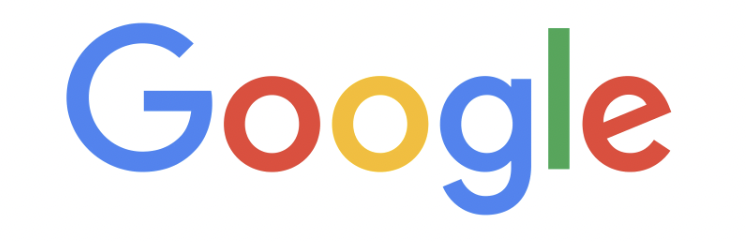

## **Goal:**

> Develop a Prototype Revenue Forecasting Tool on GCP. Using Google’s tools and data on GCP, demonstrate the ability to create and deploy a revenue forecasting tool. The tool should:
- Demonstrate a compelling user experience.
- Provide useful forecasts.
- Be built in a way that highlights the ease of use and potential of GCP and the associated tools.



##**Contents**:
1. Setup Libraries and connecting to the environment
2. Data Transformations/Preprocessing
    - Basic transformations and assessment
    - Adding calculated columns
    - EDA Plots


## **1. SETTING UP LIBRARIES AND CONNECTING TO THE ENVIRONMENT**

In [ ]:
#Importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly as py
from matplotlib.pyplot import figure

import seaborn as sns
sns.set()
import sys
sys.version
import scipy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import csv
import scipy.stats

### **Connecting to google drive**

In [ ]:
# Connect to Google Drive Storage
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
#To run the following create a copy of the dataset folder in your google drive
DATA_PATH="/content/drive/MyDrive/Google_Capstone/"

In [ ]:
#Getting the population data
population_df= pd.read_csv(DATA_PATH + "population_data.csv", index_col=False)

In [ ]:
#Getting the Breweries data
brewery_df= pd.read_csv(DATA_PATH + "breweries_data_2.csv", index_col=False)

In [ ]:
#Getting weather data
weather_data=pd.read_csv(DATA_PATH + "weather_data.csv", index_col=False)

### **Connecting to bigquery**

In [ ]:
#Account verification
# NOTE: Use the google account that is connected to BigQuery to run this notebook
from google.colab import auth
auth.authenticate_user()

In [ ]:
#Connecting to bigquery project
from google.cloud import bigquery
client = bigquery.Client(project='ssd-mbai2022')

### **Dataset**
Iowa liquour sales dataset from Google's bigquery public dataset has been used. We will be using the 6 month's data  of 2022.

In [ ]:
#getting the dataset and table name content into a dataframe
sql_query = ('''SELECT * FROM iowa_project.alcohol_sales where date >= "2022-01-01" ''')
df_org = client.query(sql_query).to_dataframe()

In [ ]:
#getting the category mappings into a dataframe
sql_query = ('''SELECT * FROM iowa_project.category_mappings ''')
liq_map_org = client.query(sql_query).to_dataframe()

In [ ]:
#Checking the dataset
df_org.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
0,INV-46373000015,2022-04-11,5159,Kimmes Rockwell City Country Store #,"730, High St",Rockwell City,50579.0,POINT (-94.638843 42.39872),13,CALHOUN,...,902291,SOOH Bartenders Bananas Over You,6,1750,9.31,13.97,4,55.88,7.0,1.84
1,INV-45490300042,2022-03-11,2655,Hy-Vee Food Store / Clarinda,1200 S 16TH ST,Clarinda,51632.0,POINT (-95.037849 40.726808),73,PAGE,...,65127,Grand Marnier Cordon Rouge,6,1000,25.55,38.33,2,76.66,2.0,0.52
2,INV-45763100008,2022-03-21,6151,University Liquors / WDM,9250 University Ave Unit 115,West Des Moines,50266.0,POINT (-93.834244 41.599769),77,POLK,...,921970,Wathens Single Barrel Bourbon,6,750,20.00,30.00,30,900.00,22.5,5.94
3,INV-45771000015,2022-03-21,4310,Fareway Stores #502 / Cherokee,205 West Bluff St,Cherokee,51012.0,POINT (-95.551866 42.75508),18,CHEROKEE,...,86251,Juarez Triple Sec,12,1000,2.42,3.63,2,7.26,2.0,0.52
4,INV-45679900026,2022-03-17,5102,Wilkie Liquors,724 1st Street NE,Mount Vernon,52314.0,POINT (-91.410401 41.918328),57,LINN,...,44266,British Navy Pussers Rum,6,750,12.50,18.75,18,337.50,13.5,3.56


In [ ]:
#Checking total number of records
row_count = df_org.shape[0]
col_count = df_org.shape[1]
print("The no. of rows in the dataframe:",row_count)
print("The no. of columns in the dataframe:",col_count)

The no. of rows in the dataframe: 1257181
The no. of columns in the dataframe: 24


In [ ]:
#Checking start date and end date
print("The start date of the dataset is :")
print(df_org['date'].min())

print("The end date of the dataset is :")
print(df_org['date'].max())

The start date of the dataset is :
2022-01-02
The end date of the dataset is :
2022-06-30


## **2. DATA TRANSFORMATIONS/ PREPROCESSING**

# **Basic transformations and assessment**

In [ ]:
#Getting a copy of the original dataframe
df=df_org

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1257181 entries, 0 to 1257180
Data columns (total 24 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   invoice_and_item_number  1257181 non-null  object 
 1   date                     1257181 non-null  object 
 2   store_number             1257181 non-null  object 
 3   store_name               1257181 non-null  object 
 4   address                  1256550 non-null  object 
 5   city                     1256550 non-null  object 
 6   zip_code                 1256550 non-null  object 
 7   store_location           1130707 non-null  object 
 8   county_number            1256550 non-null  object 
 9   county                   1256550 non-null  object 
 10  category                 1257181 non-null  object 
 11  category_name            1257181 non-null  object 
 12  vendor_number            1257181 non-null  object 
 13  vendor_name              1257181 non-null 

**Checking for data types**

In [ ]:
df.dtypes

invoice_and_item_number     object
date                        object
store_number                object
store_name                  object
address                     object
city                        object
zip_code                    object
store_location              object
county_number               object
county                      object
category                    object
category_name               object
vendor_number               object
vendor_name                 object
item_number                 object
item_description            object
pack                         int64
bottle_volume_ml             int64
state_bottle_cost          float64
state_bottle_retail        float64
bottles_sold                 int64
sale_dollars               float64
volume_sold_liters         float64
volume_sold_gallons        float64
dtype: object

In [ ]:
#Converting column with data type object to string
df['invoice_and_item_number'] = df['invoice_and_item_number'].astype('string')
df['date'] = df['date'].astype('string')
df['store_number'] = df['store_number'].astype('string')
df['store_name'] = df['store_name'].astype('string')
df['address'] = df['address'].astype('string')
df['city'] = df['city'].astype('string')
df['zip_code'] = df['zip_code'].astype('string')
df['store_location'] = df['store_location'].astype('string')
df['county_number'] = df['county_number'].astype('string')
df['county'] = df['county'].astype('string')
df['category'] = df['category'].astype('string')
df['category_name'] = df['category_name'].astype('string')
df['vendor_number'] = df['vendor_number'].astype('string')
df['vendor_name'] = df['vendor_name'].astype('string')
df['item_number'] = df['item_number'].astype('string')
df['item_description'] = df['item_description'].astype('string')

In [ ]:
#Converting date column's data type to date
df['date'] = pd.to_datetime(df['date'])

#Getting date range
print("The starting date of the date range is :",(df['date'].min()))
print("The ending date of the date range is :",df['date'].max())

The starting date of the date range is : 2022-01-02 00:00:00
The ending date of the date range is : 2022-06-30 00:00:00


In [ ]:
df.dtypes

invoice_and_item_number            string
date                       datetime64[ns]
store_number                       string
store_name                         string
address                            string
city                               string
zip_code                           string
store_location                     string
county_number                      string
county                             string
category                           string
category_name                      string
vendor_number                      string
vendor_name                        string
item_number                        string
item_description                   string
pack                                int64
bottle_volume_ml                    int64
state_bottle_cost                 float64
state_bottle_retail               float64
bottles_sold                        int64
sale_dollars                      float64
volume_sold_liters                float64
volume_sold_gallons               

In [ ]:
df.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
0,INV-46373000015,2022-04-11,5159,Kimmes Rockwell City Country Store #,"730, High St",Rockwell City,50579.0,POINT (-94.638843 42.39872),13,CALHOUN,...,902291,SOOH Bartenders Bananas Over You,6,1750,9.31,13.97,4,55.88,7.0,1.84
1,INV-45490300042,2022-03-11,2655,Hy-Vee Food Store / Clarinda,1200 S 16TH ST,Clarinda,51632.0,POINT (-95.037849 40.726808),73,PAGE,...,65127,Grand Marnier Cordon Rouge,6,1000,25.55,38.33,2,76.66,2.0,0.52
2,INV-45763100008,2022-03-21,6151,University Liquors / WDM,9250 University Ave Unit 115,West Des Moines,50266.0,POINT (-93.834244 41.599769),77,POLK,...,921970,Wathens Single Barrel Bourbon,6,750,20.00,30.00,30,900.00,22.5,5.94
3,INV-45771000015,2022-03-21,4310,Fareway Stores #502 / Cherokee,205 West Bluff St,Cherokee,51012.0,POINT (-95.551866 42.75508),18,CHEROKEE,...,86251,Juarez Triple Sec,12,1000,2.42,3.63,2,7.26,2.0,0.52
4,INV-45679900026,2022-03-17,5102,Wilkie Liquors,724 1st Street NE,Mount Vernon,52314.0,POINT (-91.410401 41.918328),57,LINN,...,44266,British Navy Pussers Rum,6,750,12.50,18.75,18,337.50,13.5,3.56


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1257181 entries, 0 to 1257180
Data columns (total 24 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   invoice_and_item_number  1257181 non-null  string        
 1   date                     1257181 non-null  datetime64[ns]
 2   store_number             1257181 non-null  string        
 3   store_name               1257181 non-null  string        
 4   address                  1256550 non-null  string        
 5   city                     1256550 non-null  string        
 6   zip_code                 1256550 non-null  string        
 7   store_location           1130707 non-null  string        
 8   county_number            1256550 non-null  string        
 9   county                   1256550 non-null  string        
 10  category                 1257181 non-null  string        
 11  category_name            1257181 non-null  string        
 12  

**Lowercasing and stripping extra spaces in columns**

In [ ]:
#lowercasing the relevant columns
df['store_name'] = df['store_name'].str.lower()
df['address'] = df['address'].str.lower()
df['city'] = df['city'].str.lower()
df['county'] = df['county'].str.lower()
df['category_name'] = df['category_name'].str.lower()
df['vendor_name'] = df['vendor_name'].str.lower()
df['item_description'] = df['item_description'].str.lower()

In [ ]:
#removing leading and trailing whitespace
df['store_name'] = df['store_name'].str.strip()
df['address'] = df['address'].str.strip()
df['city'] = df['city'].str.strip()
df['county'] = df['county'].str.strip()
df['category_name'] = df['category_name'].str.strip()
df['vendor_name'] = df['vendor_name'].str.strip()
df['item_description'] = df['item_description'].str.strip()

In [ ]:
#removing double spaces between words
df['store_name'] = df['store_name'].str.replace('  ', ' ')
df['address'] = df['address'].str.replace('  ', ' ')
df['city'] = df['city'].str.replace('  ', ' ')
df['county'] = df['county'].str.replace('  ', ' ')
df['category_name'] = df['category_name'].str.replace('  ', ' ')
df['vendor_name'] = df['vendor_name'].str.replace('  ', ' ')
df['item_description'] = df['item_description'].str.replace('  ', ' ')

**Checking for NULLS**

In [ ]:
display(df.isna().sum())

invoice_and_item_number         0
date                            0
store_number                    0
store_name                      0
address                       631
city                          631
zip_code                      631
store_location             126474
county_number                 631
county                        631
category                        0
category_name                   0
vendor_number                   0
vendor_name                     0
item_number                     0
item_description                0
pack                            0
bottle_volume_ml                0
state_bottle_cost               0
state_bottle_retail             0
bottles_sold                    0
sale_dollars                    0
volume_sold_liters              0
volume_sold_gallons             0
dtype: int64

**Dropping data**

In [ ]:
#Store location can be dropped (too many NULLS)
df=df.drop(columns=['store_location'])
#Very less data is lost if we remove county and it's important for location category so can't have NULLS
df = df.dropna(axis=0,subset=['county'])

In [ ]:
display(df.isna().sum())

invoice_and_item_number    0
date                       0
store_number               0
store_name                 0
address                    0
city                       0
zip_code                   0
county_number              0
county                     0
category                   0
category_name              0
vendor_number              0
vendor_name                0
item_number                0
item_description           0
pack                       0
bottle_volume_ml           0
state_bottle_cost          0
state_bottle_retail        0
bottles_sold               0
sale_dollars               0
volume_sold_liters         0
volume_sold_gallons        0
dtype: int64

**Checking for unique values in the dataset**

Category_name column

In [ ]:
#Checking column category_name
df['category_name'].unique()

<StringArray>
[                 'special order items',
          'imported cordials & liqueur',
              'bottled in bond bourbon',
                           'triple sec',
                        'aged dark rum',
                      'coffee liqueurs',
                         'flavored gin',
  'american distilled spirit specialty',
                             'gold rum',
                   'single malt scotch',
  'imported distilled spirit specialty',
       'neutral grain spirits flavored',
                'neutral grain spirits',
                   'american sloe gins',
                'straight rye whiskies',
       'temporary & specialty packages',
       'single barrel bourbon whiskies',
                               'mezcal',
                        'corn whiskies',
                        'imported gins',
                            'white rum',
                           'spiced rum',
                         'flavored rum',
                        'mixto tequila',
  

In [ ]:
#As there are double category names for the same thing

#Extra 's' in the name
df['category_name'] = df['category_name'].replace({'american cordials & liqueur':'american cordials & liqueurs'})
df['category_name'] = df['category_name'].replace({'imported cordials & liqueur':'imported cordials & liqueurs'})
df['category_name'] = df['category_name'].replace({'american distilled spirit specialty':'american distilled spirits specialty'})
df['category_name'] = df['category_name'].replace({'imported vodkas':'imported vodka'})
df['category_name'] = df['category_name'].replace({'cocktails /rtd':'cocktails / rtd'})
df['category_name'] = df['category_name'].replace({'imported distilled spirits specialty':'imported distilled spirit specialty'})
df['category_name'] = df['category_name'].replace({'american vodkas':'american vodka'})

#Checking column category_name
df['category_name'].unique()

array(['special order items', 'imported cordials & liqueurs',
       'bottled in bond bourbon', 'triple sec', 'aged dark rum',
       'coffee liqueurs', 'flavored gin',
       'american distilled spirits specialty', 'gold rum',
       'single malt scotch', 'imported distilled spirit specialty',
       'neutral grain spirits flavored', 'neutral grain spirits',
       'american sloe gins', 'straight rye whiskies',
       'temporary & specialty packages', 'single barrel bourbon whiskies',
       'mezcal', 'corn whiskies', 'imported gins', 'white rum',
       'spiced rum', 'flavored rum', 'mixto tequila', 'cocktails / rtd',
       'cream liqueurs', 'irish whiskies', 'american vodka',
       'imported vodka', 'scotch whiskies', 'whiskey liqueur',
       'blended whiskies', 'american brandies', 'american dry gins',
       'american schnapps', 'canadian whiskies', 'imported brandies',
       'imported dry gins', 'imported schnapps', '100% agave tequila',
       'tennessee whiskies', 'american

In [ ]:
df['category_name'].nunique()

47

County column

In [ ]:
df['county'].unique()

<StringArray>
[   'calhoun',       'page',       'polk',   'cherokee',       'linn',
    'dubuque',    'johnson',   'marshall',     'bremer',     'dallas',
        'lee',      'story',    'clinton',   'woodbury', 'black hawk',
      'scott',     'marion',    'fayette', 'washington',  'van buren',
     'jasper',  'jefferson',     'shelby',  'poweshiek', 'cerro gord',
 'pottawatta',     'hardin',    'wapello',    'madison',   'crawford',
    'mahaska',      'boone',       'iowa',      'union',       'lyon',
  'dickinson',  'muscatine',     'obrien',    'kossuth', 'des moines',
  'winnebago',   'humboldt',  'appanoose',       'cass',      'sioux',
     'greene',      'jones',    'webster',    'carroll',        'sac',
 'pocahontas',   'buchanan',        'ida',     'benton',      'adair',
    'hancock',       'tama', 'winneshiek',     'clarke',      'davis',
   'plymouth',   'mitchell',      'henry',    'audubon',     'butler',
       'clay', 'buena vist',     'keokuk',   'harrison',    'cl

Vendor_name column

In [ ]:
df['vendor_name'].unique()

<StringArray>
[           'charles jacquin et cie',                   'campari america',
          'frank lin distillers pro',                         'luxco inc',
           'shaw-ross international',                 'pernod ricard usa',
                   'azzurre spirits',           'piedmont distillers inc',
                   'bacardi usa inc',                 'jinro america inc',
 ...
         'surville enterprises corp',      'big derby distilling company',
 'hpsepicurean llc / preiss imports',            'apostrophe brands, llc',
                 'keen beverage llc',                'ransom spirits llc',
   'mpl brands nv inc/ patco brands',                     'casa 1921 llc',
          'splinter group napa, llc',        'seven jars distillery, llc']
Length: 211, dtype: string

Store_name column

In [ ]:
df['store_name'].unique()

<StringArray>
['kimmes rockwell city country store #',
         'hy-vee food store / clarinda',
             'university liquors / wdm',
       'fareway stores #502 / cherokee',
                       'wilkie liquors',
                  "sid's beverage shop",
                       "john's grocery",
          'hy-vee food store / dubuque',
                    'benz distributing',
                      'smoke shop, the',
 ...
             'walgreens #11193 / boone',
     'jet stop west point / west point',
             'templeton distilling llc',
              'hy-vee gas #5018 / ames',
                'best deals / waterloo',
     'jet stop new london / new london',
           'walgreens #05119 / clinton',
               'gopuff / north liberty',
             'tycoga vineyard & winery',
                 'broadbent distillery']
Length: 1942, dtype: string

City column

In [ ]:
df['city'].unique()

<StringArray>
[  'rockwell city',        'clarinda', 'west des moines',        'cherokee',
    'mount vernon',         'dubuque',       'iowa city',    'cedar rapids',
      'des moines',    'marshalltown',
 ...
      'blairstown',        'houghton',         'seymour',      'birmingham',
          'lamont',        'leclaire',         'aurelia',           'salem',
       'bonaparte',         'denmark']
Length: 449, dtype: string

**Checking for correlation**

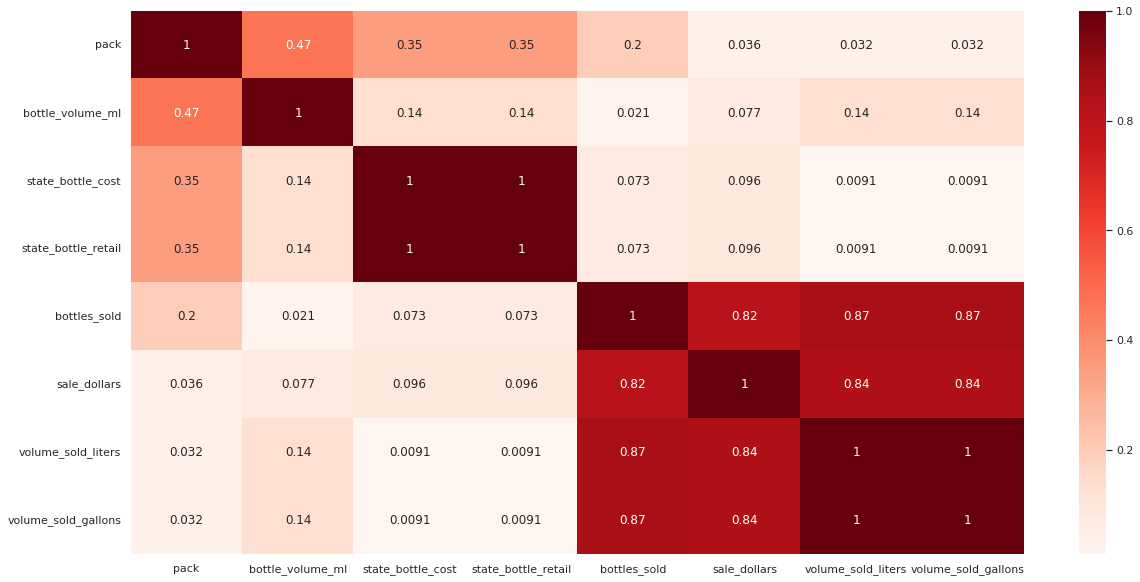

In [ ]:
#Checking for correlation between features
corr_matrix = df.corr().abs()
plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix, annot=True, cmap="Reds")
plt.show()

In [ ]:
#Based on heatmap we can drop volume_sold_liters column
df=df.drop(columns=['volume_sold_liters'])

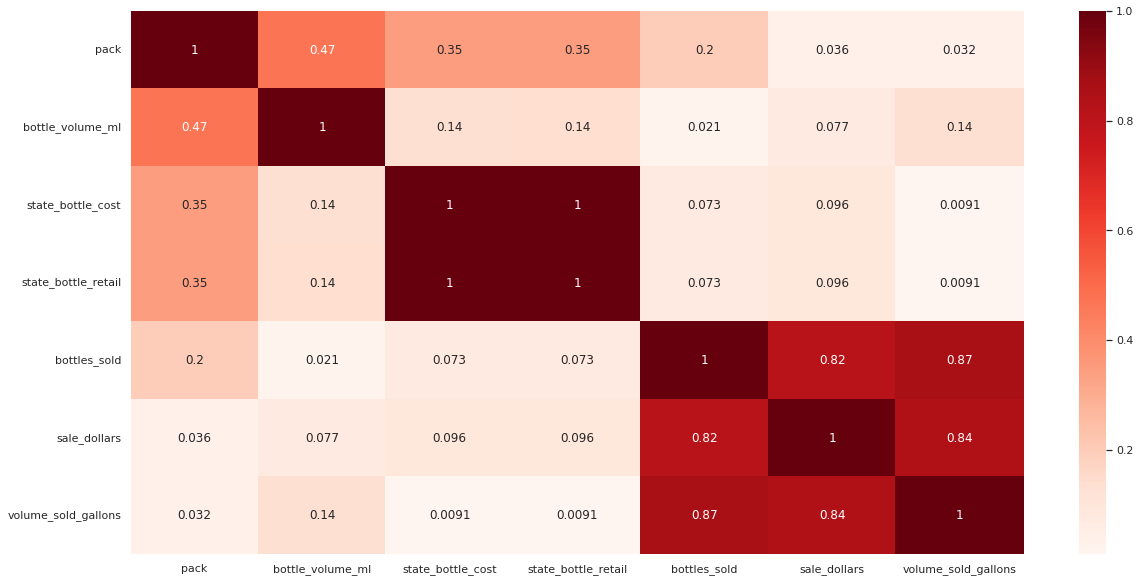

In [ ]:
#Checking for correlation between features
corr_matrix = df.corr().abs()
plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix, annot=True, cmap="Reds")
plt.show()

# **Adding calculated columns**

**Adding a main category colum for the liquor category names**

In [ ]:
#Creating a copy of the category name mapping
liq_map=liq_map_org
liq_map

,category_name,category_name_clean,Main_Catogry,Parent_Category,Imported,Total_Sales
0,None,None,None,None,NaN,"$4,816,156.44"
1,Flavored Gin,flavored gin,Gin,Gin,NaN,"$1,156,387.47"
2,FLAVORED GINS,flavored gins,Gin,Gin,NaN,"$576,449.58"
3,PUERTO RICO & VIRGIN ISLANDS RUM,puerto rico & virgin islands rum,Rum,Rum,NaN,"$39,716,893.23"
4,White Rum,white rum,Rum,Rum,NaN,"$38,240,069.55"
...,...,...,...,...,...,...
131,Imported Whiskies,imported whiskies,Whiskey/Whisky,Whiskey/Whisky,1.0,"$7,819.92"
132,Imported Cordials & Liqueurs,imported cordials & liqueurs,Cordials & liqueurs,Cordials & liqueurs,1.0,"$51,758,538.19"
133,MISC. IMPORTED CORDIALS & LIQUEURS,misc. imported cordials & liqueurs,Cordials & liqueurs,Cordials & liqueurs,1.0,"$37,832,800.36"
134,Imported Cordials & Liqueur,imported cordials & liqueur,Cordials & liqueurs,Cordials & liqueurs,1.0,"$1,911,505.75"


In [ ]:
#Removing NULLS from the mapping
liq_map = liq_map.dropna(axis=0,subset=['category_name'])

#Dropping unnecessary columns
liq_map=liq_map.drop(columns=['category_name','Parent_Category','Imported','Total_Sales'])

#Removing any duplicate rows
liq_map = liq_map.drop_duplicates()

#Converting everything to lower case
liq_map['category_name_clean'] = liq_map['category_name_clean'].str.lower()
liq_map['Main_Catogry'] = liq_map['Main_Catogry'].str.lower()

#removing leading and trailing spaces
liq_map['category_name_clean'] = liq_map['category_name_clean'].str.strip()
liq_map['Main_Catogry'] = liq_map['Main_Catogry'].str.strip()

#removing double spaces between words
liq_map['category_name_clean'] = liq_map['category_name_clean'].str.replace('  ', ' ')
liq_map['Main_Catogry'] = liq_map['Main_Catogry'].str.replace('  ', ' ')

liq_map

,category_name_clean,Main_Catogry
1,flavored gin,gin
2,flavored gins,gin
3,puerto rico & virgin islands rum,rum
4,white rum,rum
5,gold rum,rum
...,...,...
131,imported whiskies,whiskey/whisky
132,imported cordials & liqueurs,cordials & liqueurs
133,misc. imported cordials & liqueurs,cordials & liqueurs
134,imported cordials & liqueur,cordials & liqueurs


In [ ]:
#Based on the mapping table we add the column in our dataset
df['main_liq_category'] = df['category_name'].map(liq_map.set_index('category_name_clean')['Main_Catogry'])
df

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,county_number,county,category,...,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_gallons,main_liq_category
0,INV-46373000015,2022-04-11,5159,kimmes rockwell city country store #,"730, high st",rockwell city,50579.0,13,calhoun,1901200,...,902291,sooh bartenders bananas over you,6,1750,9.31,13.97,4,55.88,1.84,specialty
1,INV-45490300042,2022-03-11,2655,hy-vee food store / clarinda,1200 s 16th st,clarinda,51632.0,73,page,1082100,...,65127,grand marnier cordon rouge,6,1000,25.55,38.33,2,76.66,0.52,cordials & liqueurs
2,INV-45763100008,2022-03-21,6151,university liquors / wdm,9250 university ave unit 115,west des moines,50266.0,77,polk,1011500,...,921970,wathens single barrel bourbon,6,750,20.00,30.00,30,900.00,5.94,whiskey/whisky
3,INV-45771000015,2022-03-21,4310,fareway stores #502 / cherokee,205 west bluff st,cherokee,51012.0,18,cherokee,1081500,...,86251,juarez triple sec,12,1000,2.42,3.63,2,7.26,0.52,triple sec
4,INV-45679900026,2022-03-17,5102,wilkie liquors,724 1st street ne,mount vernon,52314.0,57,linn,1062300,...,44266,british navy pussers rum,6,750,12.50,18.75,18,337.50,3.56,rum
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257176,INV-44622700007,2022-02-10,2515,hy-vee food store #1 / mason city,2400 4th st sw,mason city,50401.0,17,cerro gord,1701100,...,26097,jacobs pardon small batch whiskey recipe #2,6,750,50.00,75.00,2,150.00,0.39,specialty
1257177,INV-44787800004,2022-02-16,6149,oelwein liquor,1011 s frederick,oelwein,50662.0,33,fayette,1701100,...,80365,ole smoky white chocolate strawberry cream,6,750,12.50,18.75,2,37.50,0.39,specialty
1257178,INV-45210800001,2022-03-02,5003,famous liquors,2604 w locust st,davenport,52804.0,82,scott,1701100,...,19054,jeffersons ocean wheated bourbon,6,750,42.50,63.75,2,127.50,0.39,specialty
1257179,INV-44568700090,2022-02-09,2501,hy-vee #2 / ames,640 lincolnway,ames,50010.0,85,story,1701100,...,64339,ciroc pomegranate,12,750,16.49,24.74,2,49.48,0.39,specialty


**Introducing profit column**

In [ ]:
# Creating new column of net profit per bottle for each bottle
df['state_per_bottle_profit'] = df['state_bottle_retail'] - df['state_bottle_cost']
df['state_total_profit'] = df['state_per_bottle_profit']*df['bottles_sold']
df.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,county_number,county,category,...,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_gallons,main_liq_category,state_per_bottle_profit,state_total_profit
0,INV-46373000015,2022-04-11,5159,kimmes rockwell city country store #,"730, high st",rockwell city,50579.0,13,calhoun,1901200,...,6,1750,9.31,13.97,4,55.88,1.84,specialty,4.66,18.64
1,INV-45490300042,2022-03-11,2655,hy-vee food store / clarinda,1200 s 16th st,clarinda,51632.0,73,page,1082100,...,6,1000,25.55,38.33,2,76.66,0.52,cordials & liqueurs,12.78,25.56
2,INV-45763100008,2022-03-21,6151,university liquors / wdm,9250 university ave unit 115,west des moines,50266.0,77,polk,1011500,...,6,750,20.00,30.00,30,900.00,5.94,whiskey/whisky,10.00,300.00
3,INV-45771000015,2022-03-21,4310,fareway stores #502 / cherokee,205 west bluff st,cherokee,51012.0,18,cherokee,1081500,...,12,1000,2.42,3.63,2,7.26,0.52,triple sec,1.21,2.42
4,INV-45679900026,2022-03-17,5102,wilkie liquors,724 1st street ne,mount vernon,52314.0,57,linn,1062300,...,6,750,12.50,18.75,18,337.50,3.56,rum,6.25,112.50


# **EDA Plots**



---


**1. Checking for sales, popularity and profit plots**


---



In [ ]:
#Top 10 largest sales liquor categories
best10 = df.groupby(['category_name','pack','date'])['sale_dollars'].sum().groupby(['category_name','pack']).max().sort_values().groupby(['category_name']).sum().sort_values(ascending=False).reset_index()

best10_plot = px.bar(best10.head(10),x=best10['category_name'].head(10), y='sale_dollars',color_discrete_sequence=["green"])
best10_plot.update_layout(
    title="10 Largest Selling Liquor Categories",
    xaxis_title="Liquor Category Name",
    yaxis_title="Sale ($)")
best10_plot.show()

### **Observation:**

* **American vodka** is the **largest selling** liquor category in the last 6 months.
* Roughly 2 times (or more) difference exists between the top 2 liquor categories vs the rest of the top largest selling liquor categories individually.



In [ ]:
#Top 10 profitable liquor categories
mostprofitable = df.groupby(['category_name','pack','date'])['state_total_profit'].sum().groupby(['category_name','pack']).max().sort_values().groupby(['category_name']).sum().sort_values(ascending=False).reset_index()

mostprofitable_plot = px.bar(mostprofitable.head(10),x=mostprofitable['category_name'].head(10), y='state_total_profit',color_discrete_sequence=["green"])
mostprofitable_plot.update_layout(
    title="The Most Profitable Liquor Categories",
    xaxis_title='Liquor Category Name',
    yaxis_title="Total profit ($)")
mostprofitable_plot.show()

### **Observation:**

* **American vodkas** is the **most profitable** liquor category in the last 6 months.
* **Profit making** liquor categories are **coincidentally** the **same** as the **top largest selling** categories.

  Also the order of profit making is same as the top largest selling liquor categories.

In [ ]:
#Top 10 popular liquor categories based on volumes sold
mostpopular = df.groupby(['category_name','pack','date'])['volume_sold_gallons'].sum().groupby(['category_name','pack']).max().sort_values().groupby(['category_name']).sum().sort_values(ascending=False).reset_index()

mostpopular_plot = px.bar(mostpopular.head(10),x=mostpopular['category_name'].head(10), y='volume_sold_gallons',color_discrete_sequence=["green"])
mostpopular_plot.update_layout(
    title="The Most Popularly Consumed Liquors",
    xaxis_title='Liquor Category Name',
    yaxis_title="Volume Sold (Gallons)")
mostpopular_plot.show()

### **Observation:**

* **American vodka** is the **most popularly consumed** liquor category in the last 6 months.

* Only **6 top selling** and profitable liquor categories **made the most popularly consumed** list.
  
  All top selling or profitable liquor categories didn't make the most popularly consumed list.

* **Cocktails/rtd, special order items, american dry gins and mixto tequilla were new additions.**

  Cocktails isn't the most profitable/largest selling but is relatively popular in demand based on volumes sold when compared to straight bourbon whiskies (which ranked 3rd in the prior two categories but hold 6th position in this category).
* **Temporary & specialty packages, irish whiskies, imported brandies and imported cordials & liquers didn't make the populary consumed list** even when though they had the largest sales.

In [ ]:
#Bottom 10 selling liquor categories based on sales
lowest10 = df.groupby(['category_name','pack','date'])['sale_dollars'].sum().groupby(['category_name','pack']).max().sort_values().groupby(['category_name']).sum().sort_values(ascending=True).reset_index()

lowest10_plot = px.bar(lowest10.head(10),x=lowest10['category_name'].head(10), y='sale_dollars',color_discrete_sequence=["maroon"])
lowest10_plot.update_layout(
    title="10 Lowest Selling Liquor Categories",
    xaxis_title="Liquor Category Name",
    yaxis_title="Sale ($)")
lowest10_plot.show()

### **Observation:**

* **Distilled spirits** has the **least amount of sales** across all liquor categories for the past 6 months.
* Roughly 12 times (or more) difference exists between the bottom 4 liquor categories vs the rest of the lowest selling liquor categories individually.



In [ ]:
#Bottom 10 profitable liquor categories
leastprofitable = df.groupby(['category_name','pack','date'])['state_total_profit'].sum().groupby(['category_name','pack']).min().sort_values().groupby(['category_name']).sum().sort_values(ascending=True).reset_index()

leastprofitable_plot = px.bar(leastprofitable.head(10),x=leastprofitable['category_name'].head(10), y='state_total_profit',color_discrete_sequence=["maroon"])
leastprofitable_plot.update_layout(
    title="The Least Profitable Liquor Categories",
    xaxis_title='Liquor Category Name',
    yaxis_title="Total profit ($)")
leastprofitable_plot.show()

### **Observation:**

* **Distilled spirits specialty** is the **least profit** making liquor category in the last 6 months.
* **The least profit making liquor categories aren't necessarily the least selling categories.**

  Only 4 least selling categories make the least profit making list (*namely: distilled spirits specialty, mezcal, flavored gin, triple sec*).

* Imported gin is the 2nd least selling liquor category but it's not even in the list when it comes to least profit making liquor category.
* Corn whiskies isn't even in the list for least selling liquor category but occupies the 3rd position when it comes to least profit making liquor category.



In [ ]:
#Top 10 least popular liquor categories based on volumes sold
leastpopular = df.groupby(['category_name','pack','date'])['volume_sold_gallons'].sum().groupby(['category_name','pack']).min().sort_values().groupby(['category_name']).sum().sort_values(ascending=True).reset_index()

leastpopular_plot = px.bar(leastpopular.head(10),x=leastpopular['category_name'].head(10), y='volume_sold_gallons',color_discrete_sequence=["maroon"])
leastpopular_plot.update_layout(
    title="The Least Popularly Consumed Liquors",
    xaxis_title='Liquor Category Name',
    yaxis_title="Volume Sold (Gallons)")
leastpopular_plot.show()

### **Observation:**

* **Distilled spirits specialty** is the **least popularly consumed** liquor category.
* **The least profit making liquor categories aren't necessarily the least popularly consumed** categories but it is highly likely.
* Only **7 least profitable** liquor categories **made** the **least popularly** **consumed** liquor category list.

### **Inference:**
* Larger sales don't necessarily mean higher profits. Same goes for least sales.
* Larger sales don't necessarily translate in popularity. Same goes for least sales.
* Larger profits don't necessaily translate into popularity. Same goes for least profits.

**Sales, Profit and Popularity may have some common liquor categories but they don't confirm a strong interrelation with one another.**




---
**2. Plots based on place**


---



In [ ]:
#Top 10 selling counties based on sales
best10_c = df.groupby(['county','pack','date'])['sale_dollars'].sum().groupby(['county','pack']).max().sort_values().groupby(['county']).sum().sort_values(ascending=False).reset_index()

best10_c_plot = px.bar(best10_c.head(10),x=best10_c['county'].head(10), y='sale_dollars',color_discrete_sequence=["green"])
best10_c_plot.update_layout(
    title="Top 10 Counties with Biggest sales",
    xaxis_title="County name",
    yaxis_title="Sale ($)")
best10_c_plot.show()

### **Observation:**

**Polk county** is the county that has the **biggest alcohol sales** in the last 6 months.

It's sales are almost two or more times the sales of other counties individually.

In [ ]:
#Top 10 selling cities based on sales
best10_c = df.groupby(['city','pack','date'])['sale_dollars'].sum().groupby(['city','pack']).max().sort_values().groupby(['city']).sum().sort_values(ascending=False).reset_index()

best10_c_plot = px.bar(best10_c.head(10),x=best10_c['city'].head(10), y='sale_dollars',color_discrete_sequence=["green"])
best10_c_plot.update_layout(
    title="Top 10 Cities with Biggest sales",
    xaxis_title="City name",
    yaxis_title="Sale ($)")
best10_c_plot.show()

### **Observation:**

* **Des Moines** is the city that has the **biggest alcohol sales** in the last 6 months.

  It's sales are almost two or more times the sales of other cities individually.

* **Cities with biggest alcohol sales coincidentally fall into the biggest alcohol selling county**.

  All 10 cities belong to one of the biggest selling county.

In [ ]:
#Bottom 10 selling counties based on sales
least10_c = df.groupby(['county','pack','date'])['sale_dollars'].sum().groupby(['county','pack']).min().sort_values().groupby(['county']).sum().sort_values(ascending=True).reset_index()

least10_c_plot = px.bar(least10_c.head(10),x=least10_c['county'].head(10), y='sale_dollars',color_discrete_sequence=["maroon"])
least10_c_plot.update_layout(
    title="Top 10 Counties with Least sales",
    xaxis_title="County name",
    yaxis_title="Sale ($)")
least10_c_plot.show()

### **Observation:**

**Marion and Wayne** are the  counties that have the **least alcohol sales** in the last 6 months.

Roughly 6$ difference between the two.

In [ ]:
#Bottom 10 selling cities based on sales
least10_c = df.groupby(['city','pack','date'])['sale_dollars'].sum().groupby(['city','pack']).min().sort_values().groupby(['city']).sum().sort_values(ascending=True).reset_index()

least10_c_plot = px.bar(least10_c.head(10),x=least10_c['city'].head(10), y='sale_dollars',color_discrete_sequence=["maroon"])
least10_c_plot.update_layout(
    title="Top 10 Cities with Least sales",
    xaxis_title="City name",
    yaxis_title="Sale ($)")
least10_c_plot.show()

### **Observation:**

* **Allerton** is the city that has the **least alcohol sales** in the last 6 months.
* **Cities with least alcohol sales don't fall into the least alcohol selling county.**
* **Only 5 cities belongs to the county with the least alcohol sales** and rest don't belong to the county with the least alcohol sales.

  Alden, Elma, Johnston, Shellsburg and Whittemore doesn't belong to any of the least alcohol selling county.


### **Inference:**
Largest county and city sales of alcohol may have some commonalities but it cannot be generalized to the least selling county and cities.




---
**3. Plots based on date**


---





In [ ]:
#Monthly sales over the 6 months
mon_sales= df.groupby(df['date'].dt.strftime('%B'))['sale_dollars'].sum().sort_values().reset_index()

#plotting the data
best10_c_plot = px.bar(mon_sales,x=mon_sales['date'],y='sale_dollars')
best10_c_plot.update_layout(
    title="Monthly sales of alcohol in Iowa",
    xaxis_title="Month",
    yaxis_title="Total Sales ($)")
best10_c_plot.show()

### **Observation:**

* **March** saw the **highest alcohol sales** within the last 6 months.
* It'd be interesting to see what activities made the alcohol sales peak in March particularly as that is the only month that is out of order against the steady increase of sales.
* Does weather play a role? Graduation?

  **Require other datasets for further investigation.**


## **SECOND WEEK EDA**



---
**4. Plots based on sales per main liquor category**


---





In [ ]:
#Top selling liquor categories based on sales
best_liq = df.groupby(['main_liq_category','pack','date'])['sale_dollars'].sum().groupby(['main_liq_category','pack']).max().sort_values().groupby(['main_liq_category']).sum().sort_values(ascending=False).reset_index()

best_liq_plot = px.bar(best_liq,x=best_liq['main_liq_category'], y='sale_dollars')
best_liq_plot.update_layout(
    title="Selling order of main liquor categories",
    xaxis_title="Main Liquor Category",
    yaxis_title="Sale ($)")
best_liq_plot.show()

### **Observation:**

* **Whiskey/whisky** liquor category has  the **highest alcohol sales** within the last 6 months.

  It's sales are almost 6 times higher than liquor categories after the top 4 liquor categories.
* Vodka, rum and tequila despite being in the top 4 face a significant drop in sales in comparison to Whiskey/whisky.





---
**5. Plots based on sales vs vendor for top 4 main liquor categories**


---





In [ ]:
#Getting the top 4 categories
liq_cat=best_liq.head(4)

#Getting a data frame of those categories only
df_cat=df[df['main_liq_category'].isin(liq_cat['main_liq_category'])]

#Renaming column before joining
liq_cat.rename(columns = {'sale_dollars':'total_sale_dollars'}, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#Top 3 selling vendors for the top 4 liquor categories based on sales
temp=df_cat.groupby(['vendor_name','main_liq_category','date'])['sale_dollars'].sum().groupby(['main_liq_category','vendor_name']).max()
temp=pd.DataFrame(temp)
best_ven=temp.groupby(level=[0,1]).sum().reset_index().sort_values(['main_liq_category', 'sale_dollars'], ascending=[1,0]).groupby('main_liq_category').head(3)

best_ven_plot = px.bar(best_ven,x=best_ven['main_liq_category'], y='sale_dollars',color='vendor_name')
best_ven_plot.update_layout(
    title="Top selling vendors for top 4 main liquor categories",
    xaxis_title="Main liquor category",
    yaxis_title="Sale ($)")
best_ven_plot.show()

### **Observation:**

* **Rum** liquor category has **diageo americas, bacardi usa inc and pernod ricard usa** has the highest selling vendors.
* **Tequila** liquor category has **proximo, bacardi usa inc and diageo americas** has the highest selling vendors.
* **Vodka** liquor category has **fifth generation inc, diageo americas and sazerac company inc** has the highest selling vendors.
* **Whiskey/whisky** liquor category has **sazerac company inc, pernod ricard usa and diageo americas** has the highest selling vendors.



In [ ]:
#Adding total sales of category
best_ven_mer=best_ven.merge(liq_cat, on="main_liq_category", how = 'inner')

#Creating percentage
best_ven_mer['percent_sales'] = (best_ven_mer['sale_dollars'] / best_ven_mer['total_sale_dollars']) * 100

#Dropping sales column
best_ven_per=best_ven_mer.drop(columns=['sale_dollars', 'total_sale_dollars'])

#Plotting the graph
best_per_plot = px.bar(best_ven_per,x=best_ven_per['main_liq_category'], y='percent_sales',color='vendor_name')
best_per_plot.update_layout(
    title="Percentage sales of top vendors in top 4 liquor categories",
    xaxis_title="Main liquor category",
    yaxis_title="Percentage sales")
best_per_plot.show()

### **Observation:**

* **Almost 78% of sales in the rum liquor category comes from these top 3 vendors.**

  Diageo americas has 52.68% sales in the rum liquor category.
* **Almost 73% of sales in the tequila liquor category comes from these top 3 vendors.**

  The tequila liquor category has an almost equal sales distribution amongst the vendors.
* **Almost 65% of sales in the vodka liquor category comes from these top 3 vendors.**

  Fifth generation inc has 44% sales in the vodka liquor category.
* **Almost 58% of sales in the whiskey/whisky liquor category comes from these top 3 vendors.**

  The Whiskey/whisky liquor category also has a fairly equal sales distribution amongst the vendors.



### **Inference:**
As expected more than atleast 65% of sales in the top 4 main liquor categories of rum, tequilla, vodka and whiskey/whisky come from 3 vendors.



---
**6. Plots based on sales vs packaging for top 4 liquor category and their top vendors**


---





In [ ]:
#Getting best vendors for each liquor category
best_vendors=best_ven_per.drop(columns=['percent_sales'])

#Creating a temporary dataframe with data of relevant liquor category and vendor names
temp_df=df.merge(best_vendors, on=["main_liq_category","vendor_name"], how = 'inner')

In [ ]:
#Top packaging based on sales
best_pack = temp_df.groupby(['main_liq_category','vendor_name','bottle_volume_ml'])['sale_dollars'].sum().groupby(['main_liq_category','bottle_volume_ml']).max().sort_values().groupby(['bottle_volume_ml']).sum().sort_values(ascending=False).reset_index()

best_pack_plot = px.bar(best_pack.head(10),x=best_pack['bottle_volume_ml'].astype("string").head(10), y='sale_dollars',color_discrete_sequence=["orange"])
best_pack_plot.update_layout(
    title="Packaging sold by top selling vendors in top selling liquor categories",
    xaxis_title="Bottle volume (mL)",
    yaxis_title="Sale ($)")
best_pack_plot.show()

### **Observation:**

* **750 mL, 1750 mL and 1000 mL bottles have the highest sales** amongst top selling vendors in the top 4 liquor categories.

* 3500 mL and 800 mL bottles have 20700 dollars and 12656.25 dollars sales respectively.



In [ ]:
#Top packaging based on sales
best_pack_gr = temp_df.groupby(['main_liq_category','vendor_name','bottle_volume_ml'])['sale_dollars'].sum().groupby(['vendor_name','bottle_volume_ml']).max()
best_pack_gr=pd.DataFrame(best_pack_gr)
best_pack_gr=best_pack_gr.groupby(level=[0,1]).sum().reset_index().sort_values(['bottle_volume_ml', 'sale_dollars'], ascending=[1,0]).groupby('bottle_volume_ml').head(3)

best_pack_gr_plot = px.bar(best_pack_gr,x=best_pack_gr['vendor_name'], y='sale_dollars',color=best_pack_gr['bottle_volume_ml'].astype("string"))
best_pack_gr_plot.update_layout(
    title="Packaging sold by top selling vendors in top selling liquor categories",
    xaxis_title="Bottle volume (mL)",
    yaxis_title="Sale ($)")
best_pack_gr_plot.show()

### **Observation:**

* **For Sazerac company inc 50 mL,750 mL and 1750 mL are the high selling bottle** volumes in the top 4 main liquor categories.

* **Proximo has only 200 mL and 50 mL bottle** volumes sold in the top 4 main liquor categories.

* **Fifth generation inc has only 1000 mL and 1750 mL bottle** volumes sold in the top 4 main liquor categories.

* **For Diageo Americas 750 mL, 1000 mL and 1750 mL are the high selling bottle** volumes in the top 4 main liquor categories.

  It's interesting to see the bottle volumes that are high selling have a different distribution than Sazerac company inc.

* **Bacardi USA inc has only 750 mL and 375 mL bottle** volumes sold in the top 4 main liquor categories.





---
**7. Elasticity analysis**


---





In [ ]:
#Creating dataframe of relevant columns for this analysis
df1=pd.DataFrame()
df1=df[['volume_sold_gallons','sale_dollars']]
df1=df1.reset_index(drop=True)
#df1['sale_dollars'] = df1['sale_dollars'].str.replace('$', '')
#Changing column type
df1=df1.astype('float64')
np.dtype(df1['sale_dollars'])

#checking for NULL
pd.DataFrame.isnull (df1).sum()

volume_sold_gallons    0
sale_dollars           0
dtype: int64

In [ ]:
#Calculating unit price column
df1['unit_price']=df1['sale_dollars']/df1['volume_sold_gallons']
#Checking for NULL
df1.isnull().sum()

volume_sold_gallons    0
sale_dollars           0
unit_price             0
dtype: int64

In [ ]:
#Removing any NULLS and checking once again
df1=df1.dropna()
df1.isnull().any()

volume_sold_gallons    False
sale_dollars           False
unit_price             False
dtype: bool

In [ ]:
#rounding the column value
df1['unit_price']=df1['unit_price'].round(1)

#Creating another data frame with grouped data
df2=df1[['unit_price','volume_sold_gallons']].groupby('unit_price').sum()
df2=df2.reset_index(drop=False)
#Making sure the column values aren't zero
df2=df2[df2['volume_sold_gallons']!=0]
df2=df2[df2['unit_price']!=0]
df2.describe()

,unit_price,volume_sold_gallons
count,3100.000000,3100.000000
mean,515.801419,995.495203
std,1338.845090,4426.373593
min,12.100000,0.010000
25%,100.675000,3.557500
50%,194.950000,22.515000
75%,476.750000,211.740000
max,35328.000000,89408.460000


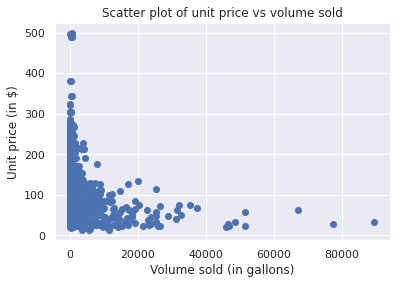

In [ ]:
#Making sure the columns are within the expected range
df2=df2[df2['volume_sold_gallons']>100]
df2=df2[df2['unit_price']<500]
plt.scatter(df2['volume_sold_gallons'], df2['unit_price'])
plt.title('Scatter plot of unit price vs volume sold')
plt.xlabel('Volume sold (in gallons)')
plt.ylabel('Unit price (in $)')
plt.rcParams["figure.figsize"] = (12,7)
plt.show()

We can see that the volume of alcohol sold is greater for lower unit prices

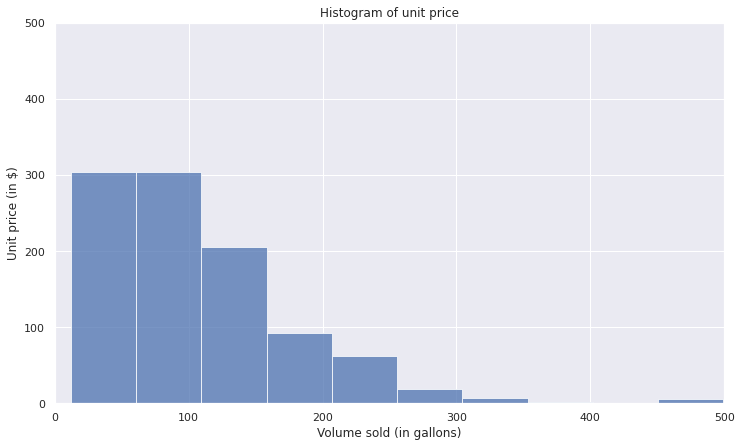

In [ ]:
#Plotting histogram of the same
plt.hist(df2['unit_price'], alpha=0.75,density=False,color='b')
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.xlabel('Volume sold (in gallons)')
plt.ylabel('Unit price (in $)')
plt.title('Histogram of unit price')
plt.rcParams["figure.figsize"] = (12,7)
plt.show()

In [ ]:
#Creating dataframe to store log values
df3=pd.DataFrame()
df3[['unit_price']] = np.log(df2[['unit_price']].values)
df3['volume_sold_gallons'] = np.log(df2['volume_sold_gallons'].values)

#Creating the linear model
X = df3['unit_price']
Y = df3['volume_sold_gallons']
#Add column of ones to X
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     volume_sold_gallons   R-squared:                       0.175
Model:                             OLS   Adj. R-squared:                  0.174
Method:                  Least Squares   F-statistic:                     212.0
Date:                 Wed, 02 Nov 2022   Prob (F-statistic):           1.09e-43
Time:                         23:48:06   Log-Likelihood:                -1745.7
No. Observations:                 1002   AIC:                             3495.
Df Residuals:                     1000   BIC:                             3505.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.8672      0.290     37.45

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



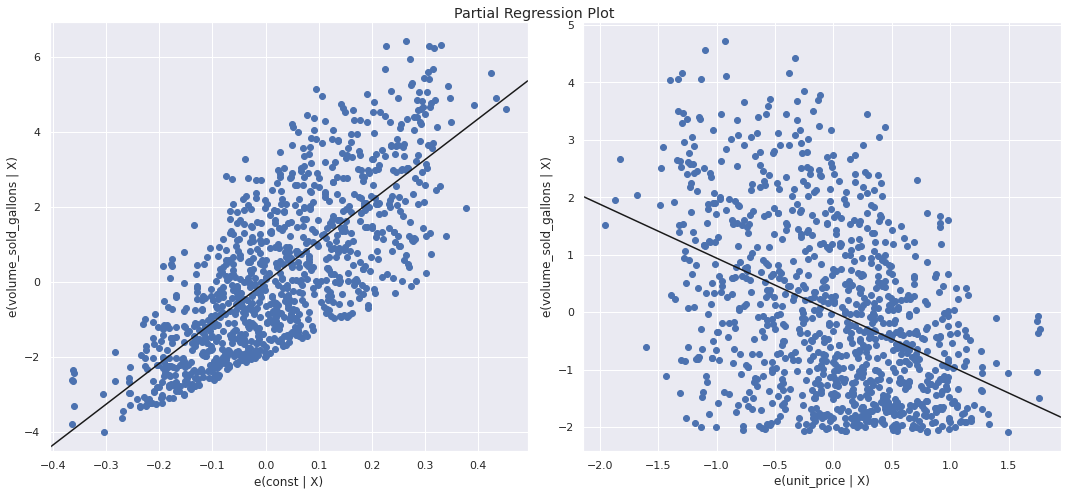

In [ ]:
fig = plt.figure(figsize=(15,7))
fig = sm.graphics.plot_partregress_grid(results, fig=fig)

In [ ]:
#reset and performing linear regression and getting coefficients
X = df3[['unit_price']]
Y = df3[['volume_sold_gallons']]
model_quantity = LinearRegression()
model_quantity.fit(X, Y)
beta_quantity = model_quantity.coef_[0]

#Creating price elasticity data frame
price_range = np.arange(0.5, 500, 0.01)
df_price_elasticity_quantity = pd.DataFrame(index = np.arange(price_range.size))
df_price_elasticity_quantity.shape
df_price_elasticity_quantity['Price_Incidence'] = price_range
df_price_elasticity_quantity['Price_Incidence'] = np.log(df_price_elasticity_quantity['Price_Incidence'].values)

#Getting the prediction
predict_quantity = model_quantity.predict(df_price_elasticity_quantity)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning:

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Price_Incidence
Feature names seen at fit time, yet now missing:
- unit_price




Text(0.5, 1.0, 'Price Elasticity')

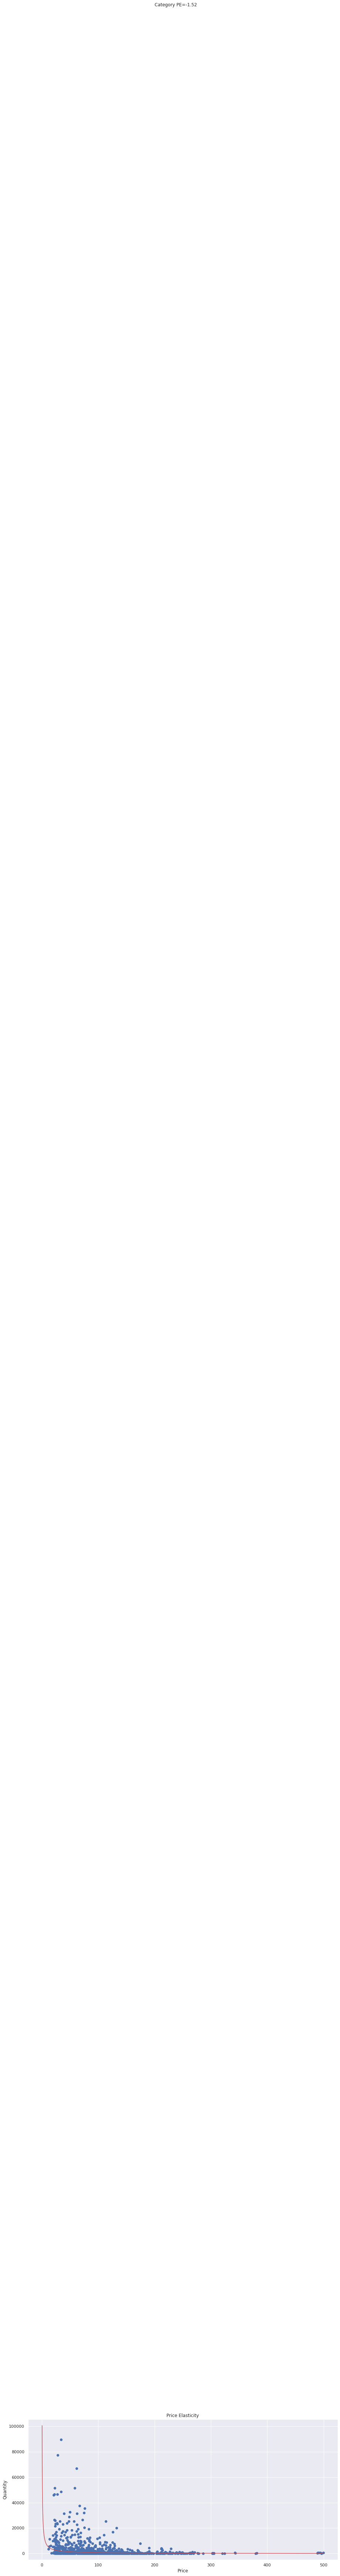

In [ ]:
#Plotting the results
plt.figure(figsize = (15, 7))
plt.plot(price_range, np.exp(predict_quantity),color='r')
plt.scatter(df2['unit_price'], df2['volume_sold_gallons'])
plt.xlabel('Price')
plt.ylabel('Quantity')
plt.text(200, 2000000, "Category PE=-1.52")
plt.title('Price Elasticity')

### **Observation:**

We can see that as price goes up the volume sold goes down.






---
**8. Combining holiday data with our alcohol sales data**


---





In [ ]:
#Getting holiday dataset
import holidays
us_holidays = holidays.UnitedStates()

#Creating holiday related features to be used for modeling
df['is_holiday'] = [date in us_holidays for date in df['date']]
df['is_holiday'] = df['is_holiday'].astype(int)

df['week_before_holiday'] = [date in us_holidays for date in (df['date']-np.timedelta64(1,'W'))]
df['week_before_holiday'] = df['week_before_holiday'].astype(int)

df['week_after_holiday'] = [date in us_holidays for date in (df['date']+np.timedelta64(1,'W'))]
df['week_after_holiday'] = df['week_after_holiday'].astype(int)

#Restructuring the column types
df = pd.concat([df.select_dtypes(exclude = ['int']),
                df.select_dtypes(include = ['int']).astype(str)],
               axis =1)

In [ ]:
#Getting the holidays date
df['is_holiday'].value_counts()

0    1229670
1      26880
Name: is_holiday, dtype: int64

In [ ]:
#Creating one holiday column
def f(x):
  if x['is_holiday'] == '1' and x['week_before_holiday'] =='0' and  x['week_after_holiday']=='0' : return "Holiday"
  #elif x['is_holiday'] == '0' and x['week_before_holiday'] =='1' and  x['week_after_holiday']=='0': return "Before"
  #elif x['is_holiday'] == '0' and x['week_before_holiday'] =='0' and  x['week_after_holiday']=='1': return "After"
  #elif x['is_holiday'] == '0' and x['week_before_holiday'] =='1' and  x['week_after_holiday']=='1': return "Between"
  #elif x['is_holiday'] == '0' and x['week_before_holiday'] =='0' and  x['week_after_holiday']=='0': return "Normal"
  #else: return 0
  else: return "Normal"

df['holiday'] = df.apply(f, axis=1)

In [ ]:
#Checking if the encoding was done accurately
df['holiday'].value_counts()

Normal     1229670
Holiday      26880
Name: holiday, dtype: int64

In [ ]:
df.head(5)

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,county_number,county,category,...,main_liq_category,state_per_bottle_profit,state_total_profit,pack,bottle_volume_ml,bottles_sold,is_holiday,week_before_holiday,week_after_holiday,holiday
0,INV-46373000015,2022-04-11,5159,kimmes rockwell city country store #,"730, high st",rockwell city,50579.0,13,calhoun,1901200,...,specialty,4.66,18.64,6,1750,4,0,0,0,Normal
1,INV-45490300042,2022-03-11,2655,hy-vee food store / clarinda,1200 s 16th st,clarinda,51632.0,73,page,1082100,...,cordials & liqueurs,12.78,25.56,6,1000,2,0,0,0,Normal
2,INV-45763100008,2022-03-21,6151,university liquors / wdm,9250 university ave unit 115,west des moines,50266.0,77,polk,1011500,...,whiskey/whisky,10.00,300.00,6,750,30,0,0,0,Normal
3,INV-45771000015,2022-03-21,4310,fareway stores #502 / cherokee,205 west bluff st,cherokee,51012.0,18,cherokee,1081500,...,triple sec,1.21,2.42,12,1000,2,0,0,0,Normal
4,INV-45679900026,2022-03-17,5102,wilkie liquors,724 1st street ne,mount vernon,52314.0,57,linn,1062300,...,rum,6.25,112.50,6,750,18,0,0,0,Normal


In [ ]:
#Adding date, month and other columns
df['day_of_year']=df['date'].dt.dayofyear
df['week_name']=df['date'].dt.day_name()
#df['week_number']=df['date'].dt.isocalendar().week
df['week_number']=df['date'].dt.week
df['year']=df['date'].dt.year
df['month']=df['date'].dt.month

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [ ]:
df.head(5)

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,county_number,county,category,...,bottles_sold,is_holiday,week_before_holiday,week_after_holiday,holiday,day_of_year,week_name,week_number,year,month
0,INV-46373000015,2022-04-11,5159,kimmes rockwell city country store #,"730, high st",rockwell city,50579.0,13,calhoun,1901200,...,4,0,0,0,Normal,101,Monday,15,2022,4
1,INV-45490300042,2022-03-11,2655,hy-vee food store / clarinda,1200 s 16th st,clarinda,51632.0,73,page,1082100,...,2,0,0,0,Normal,70,Friday,10,2022,3
2,INV-45763100008,2022-03-21,6151,university liquors / wdm,9250 university ave unit 115,west des moines,50266.0,77,polk,1011500,...,30,0,0,0,Normal,80,Monday,12,2022,3
3,INV-45771000015,2022-03-21,4310,fareway stores #502 / cherokee,205 west bluff st,cherokee,51012.0,18,cherokee,1081500,...,2,0,0,0,Normal,80,Monday,12,2022,3
4,INV-45679900026,2022-03-17,5102,wilkie liquors,724 1st street ne,mount vernon,52314.0,57,linn,1062300,...,18,0,0,0,Normal,76,Thursday,11,2022,3


In [ ]:
#Checking the sales for week
week_df = df.groupby(['week_number','month','year','holiday'])['sale_dollars'].sum().groupby(['week_number','month','holiday']).max().sort_values().groupby(['week_number','holiday']).sum().sort_values(ascending=False).reset_index()
week_df=pd.DataFrame(week_df)

week_plot_df = week_df[week_df['week_number'] != 52]

week_plot = px.bar(week_plot_df,x=week_plot_df['week_number'], y='sale_dollars',color='holiday')
week_plot.update_layout(
    title="Sales throughout the weeks",
    xaxis_title="Week number",
    yaxis_title="Sale ($)")
week_plot.show()

### **Observation:**

* There isn't a consistent spike before and after holiday week.




In [ ]:
#Checking the sales for week
week_df = df.groupby(['week_name','week_number','month','year','holiday'])['sale_dollars'].sum().groupby(['week_name','week_number','month','holiday']).max().sort_values().groupby(['week_name','month']).sum().sort_values(ascending=False).reset_index()
week_df=pd.DataFrame(week_df)

week_plot = px.bar(week_df,x=week_df['month'], y='sale_dollars',color='week_name')
week_plot.update_layout(
    title="Sales throughout the days of the week",
    xaxis_title="Month of the week",
    yaxis_title="Sale ($)")
week_plot.show()

### **Observation:**
* **With the exception of Saturday and Sunday the distribution of alcohol sales is fairly equivalent across various weeks of the day.**
* **Wednesdays and Thursdays have slightly higher alcohol sales.**
  - **January** had higher sales on **Monday**, Wednesday and Thursday.
  - **February** had higher sales on Wednesday, Thursday and **Tuesday**.
  - **March** had higher sales on Wednesday, Thursday and **Tuesday**.
  - **April** had higher sales on Thursday, **Friday** and Wednesday.
  - **May** had higher sales on **Tuesday**, Thursday and Wednesday.
  - **June** had higher sales on Wednesday, Thursday and **Monday**.




In [ ]:
#Getting list of holidays on days of week
week_df = df[['week_name','month','holiday']]
week_df=week_df.drop_duplicates()

#Getting entries that have a holiday
holiday=week_df[week_df["holiday"].str.contains("Holiday")]

In [ ]:
holiday.sort_values(["month"])

,week_name,month,holiday
38,Monday,1,Holiday
135,Monday,2,Holiday
45517,Monday,5,Holiday
189,Monday,6,Holiday
15304,Sunday,6,Holiday


### **Observation:**
* The slight peak in total sales on Monday in January could be due to holiday.
* Holiday on Monday didn't rise total sales of Monday in February.
* Holiday on Monday didn't rise total sales of Monday in May.
* The slight peak in total sales on Monday in January could be due to holiday.
* Since sunday was a holiday as well in June; the slight peak in total sales on Saturday (in opposition to general trend) could be due to a holiday.




### **Takeaway:**
* Further granular level investigation is needed.
* There is slight trend with respect to holidays but at this stage it's still inconclusive.




---
**9. Getting alcohol store density**


---





In [ ]:
#Getting alcohol stores count in each city
alcohol_stores = df.groupby('city')['store_number'].nunique()
alcohol_stores

city
ackley      1
adair       2
adel        5
afton       1
akron       1
           ..
winthrop    2
woodbine    2
woodward    1
wyoming     1
zwingle     1
Name: store_number, Length: 449, dtype: int64

In [ ]:
#Converting the store information to data frame
stores = alcohol_stores.to_frame(name = 'no.ofstores')
stores

,no.ofstores
city,
ackley,1
adair,2
adel,5
afton,1
akron,1
...,...
winthrop,2
woodbine,2
woodward,1


In [ ]:
#Top 10 highest number of stores
stores.nlargest(columns=['no.ofstores'],n=10)

,no.ofstores
city,
cedar rapids,90
des moines,88
davenport,57
waterloo,49
council bluffs,43
dubuque,43
west des moines,43
sioux city,39
ames,38


In [ ]:
#Top 10 selling cities and their store count based on sales
best10_c = df.groupby(['city','pack','date'])['sale_dollars'].sum().groupby(['city','pack']).max().sort_values().groupby(['city']).sum().sort_values(ascending=False).reset_index()
#Adding alcohol store count separately to avoid sum
best10_c=best10_c.merge(stores, how='inner', on='city')

best10_c_plot = px.bar(best10_c.head(10),x=best10_c['city'].head(10), y='sale_dollars',color='no.ofstores')
best10_c_plot.update_layout(
    title="Top 10 Cities with Biggest sales",
    xaxis_title="City name",
    yaxis_title="Sale ($)")
best10_c_plot.show()

### **Observation:**
* **Des Moines is the city with highest alcohol sales and a store count of 88.**
* **Cedar Rapids has the highest store count of 90 but is significantly bringing less sales in comparison to Des Moines.**
* **Most cities with highest no. of stores are in the top 10 alcohol selling list but not in the same order.**
  - Iowa city and Dubuque are in the top 10 highest no. of stores but aren't in the top alcohol selling city list.
  - Ankeny and Cedar falls aren't in the top 10 highest no. of stores but are in the top alcohol selling city list.




In [ ]:
#Top 10 highest number of stores
stores.nsmallest(columns=['no.ofstores'],n=10)

,no.ofstores
city,
ackley,1
afton,1
akron,1
albert city,1
albion,1
alburnett,1
allerton,1
alton,1
amana,1


In [ ]:
#Bottom 10 selling cities and their store count based on sales
least10_c = df.groupby(['city','pack','date'])['sale_dollars'].sum().groupby(['city','pack']).min().sort_values().groupby(['city']).sum().sort_values(ascending=True).reset_index()
#Adding alcohol store count separately to avoid sum
least10_c=least10_c.merge(stores, how='inner', on='city')

least10_c_plot = px.bar(least10_c.head(10),x=least10_c['city'].head(10), y='sale_dollars',color='no.ofstores')
least10_c_plot.update_layout(
    title="Top 10 Cities with Least sales",
    xaxis_title="City name",
    yaxis_title="Sale ($)")
least10_c_plot.show()

### **Observation:**
* **Allerton is the city with lowest alcohol sales and a store count of 1.**
* **Many cities with lowest no. of stores are in the bottom 10 alcohol selling list but not in the same order.**
  - Alden, Sanborn, Johnston and Elkader aren't in the bottom 10 "no. of stores" but are in the bottom 10 alcohol selling city list.
  - A lot of cities that are in bottom 10 "no. of stores" but aren't in the bottom 10 alcohol selling city list.





### **Inference:**
* There is some relationship between store count having an influence, especially at the extremeties, on the total alcohol sales of the city.

  But it cannot be generalized all across.

* No. of stores in a city is not the only factor that is responsible for a city to have high/low sales.
  
* Population is another factor that could be explored in combination with this to understand the trend.




## **THIRD WEEK EDA**



---
**9. Combining population with alcohol sales data**


---





In [ ]:
#Reading the dataset from drive
df_pop=population_df
df_pop.head(5)

,SUMLEV,STATE,COUNTY,PLACE,COUSUB,CONCIT,PRIMGEO_FLAG,FUNCSTAT,NAME,STNAME,ESTIMATESBASE2020,POPESTIMATE2020,POPESTIMATE2021,%YoY increase,POPESTIMATE2022
0,40,19,0,0,0,0,0,A,Iowa,Iowa,3190369,3188669,3193079,0.001383,3197495
1,162,19,0,190,0,0,0,A,Ackley city,Iowa,1596,1591,1576,-0.009428,1561
2,162,19,0,235,0,0,0,A,Ackworth city,Iowa,118,118,119,0.008475,120
3,162,19,0,370,0,0,0,A,Adair city,Iowa,795,793,797,0.005044,801
4,162,19,0,505,0,0,0,A,Adel city,Iowa,6154,6177,6276,0.016027,6377


In [ ]:
#Converting columns to lowercase
df_pop['NAME'] = df_pop['NAME'].str.lower()
df_pop['STNAME'] = df_pop['STNAME'].str.lower()

#Removing whitespaces
df_pop['NAME'] = df_pop['NAME'].str.strip()
df_pop['STNAME'] = df_pop['STNAME'].str.strip()

#Removing double spaces
df_pop['NAME'] = df_pop['NAME'].str.replace('  ', ' ')
df_pop['STNAME'] = df_pop['STNAME'].str.replace('  ', ' ')

#Replacing the additinal word in the city name column
df_pop['NAME'] = df_pop['NAME'].str.replace(' city', '')
df_pop['NAME'] = df_pop['NAME'].str.replace('.', '')
df_pop['NAME'] = df_pop['NAME'].str.replace('mount', 'mt')
df_pop['NAME'] = df_pop['NAME'].str.replace('jewell junction', 'jewell')

#Dropping duplicate rows
df_pop=df_pop.drop_duplicates()
df_pop.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



,SUMLEV,STATE,COUNTY,PLACE,COUSUB,CONCIT,PRIMGEO_FLAG,FUNCSTAT,NAME,STNAME,ESTIMATESBASE2020,POPESTIMATE2020,POPESTIMATE2021,%YoY increase,POPESTIMATE2022
0,40,19,0,0,0,0,0,A,iowa,iowa,3190369,3188669,3193079,0.001383,3197495
1,162,19,0,190,0,0,0,A,ackley,iowa,1596,1591,1576,-0.009428,1561
2,162,19,0,235,0,0,0,A,ackworth,iowa,118,118,119,0.008475,120
3,162,19,0,370,0,0,0,A,adair,iowa,795,793,797,0.005044,801
4,162,19,0,505,0,0,0,A,adel,iowa,6154,6177,6276,0.016027,6377


In [ ]:
#Creating a copy of main dataframe
df_main=df

#Replacing names in the city name column
df_main['city'] = df_main['city'].str.replace(' city', '')
df_main['city'] = df_main['city'].str.replace('mount', 'mt')
df_main['city'] = df_main['city'].str.replace('saint', 'st')
df_main['city'] = df_main['city'].str.replace('mounds', 'mound')
df_main['city'] = df_main['city'].str.replace('lonetree', 'lone tree')
df_main['city'] = df_main['city'].str.replace('leclaire', 'le claire')
df_main['city'] = df_main['city'].str.replace('otumwa', 'ottuwma')
df_main['city'] = df_main['city'].str.replace('clearlake', 'clear lake')

In [ ]:
#Creating a temporary dataframe to store combined results of alcohol sales and population data
temp_df=pd.merge(df_main,df_pop, left_on=['city'], right_on=['NAME'], how = 'left')
temp_df.head(5)

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,county_number,county,category,...,CONCIT,PRIMGEO_FLAG,FUNCSTAT,NAME,STNAME,ESTIMATESBASE2020,POPESTIMATE2020,POPESTIMATE2021,%YoY increase,POPESTIMATE2022
0,INV-46373000015,2022-04-11,5159,kimmes rockwell city country store #,"730, high st",rockwell,50579.0,13,calhoun,1901200,...,0.0,0.0,A,rockwell,iowa,1072.0,1068.0,1060.0,-0.007491,1052.0
1,INV-46373000015,2022-04-11,5159,kimmes rockwell city country store #,"730, high st",rockwell,50579.0,13,calhoun,1901200,...,0.0,0.0,A,rockwell,iowa,2269.0,2259.0,2258.0,-0.000443,2257.0
2,INV-46373000015,2022-04-11,5159,kimmes rockwell city country store #,"730, high st",rockwell,50579.0,13,calhoun,1901200,...,0.0,1.0,A,rockwell,iowa,2269.0,2259.0,2258.0,-0.000443,2257.0
3,INV-46373000015,2022-04-11,5159,kimmes rockwell city country store #,"730, high st",rockwell,50579.0,13,calhoun,1901200,...,0.0,1.0,A,rockwell,iowa,1072.0,1068.0,1060.0,-0.007491,1052.0
4,INV-45490300042,2022-03-11,2655,hy-vee food store / clarinda,1200 s 16th st,clarinda,51632.0,73,page,1082100,...,0.0,0.0,A,clarinda,iowa,5495.0,5487.0,5493.0,0.001093,5499.0


In [ ]:
#Checking for NULLs are merging the dataframe
temp_df.isna().sum()

invoice_and_item_number       0
date                          0
store_number                  0
store_name                    0
address                       0
city                          0
zip_code                      0
county_number                 0
county                        0
category                      0
category_name                 0
vendor_number                 0
vendor_name                   0
item_number                   0
item_description              0
state_bottle_cost             0
state_bottle_retail           0
sale_dollars                  0
volume_sold_gallons           0
main_liq_category             0
state_per_bottle_profit       0
state_total_profit            0
pack                          0
bottle_volume_ml              0
bottles_sold                  0
is_holiday                    0
week_before_holiday           0
week_after_holiday            0
holiday                       0
day_of_year                   0
week_name                     0
week_num

In [ ]:
#Finding the cities in main dataframe that aren't there in population dataset
no_pop_data=temp_df[temp_df['NAME'].isna()]
no_pop_data['city'].unique()

array(['amana', 'washburn', 'pleasant valley', 'denmark'], dtype=object)

Note: Amana, Pleasant Valley, Washburn and Denmark data couldn't be found in the population dataset

In [ ]:
#Cities with high sales
#high_sales= temp_df.groupby(['city','pack','date'])['sale_dollars'].sum().groupby(['city','pack'])#.max().sort_values().groupby(['city']).sum().sort_values(ascending=False).reset_index()

#Cities with low sales
#low_sales= temp_df.groupby(['city','pack','date'])['sale_dollars'].sum().groupby(['city','pack']).min().sort_values().groupby(['city']).sum().sort_values(ascending=True).reset_index()

#Sales data
sales= temp_df.groupby(['city'])['sale_dollars'].sum()
sales=sales.to_frame(name = 'total_sales')

#Getting store data
store_count = temp_df.groupby('city')['store_number'].nunique()
store_count=store_count.to_frame(name = 'no.ofstores')

#Getting population data
pop_data= temp_df[['city','POPESTIMATE2022']]
pop_data=pop_data.drop_duplicates()

In [ ]:
#Merging all data frames for high selling cities
data=pd.merge(sales,pop_data, on='city', how = 'inner')
data=pd.merge(data,store_count, on='city', how = 'left')

#Creating a column for store density and per capita sales
data['per_capita_sales']=round(data['total_sales']/data['POPESTIMATE2022'],2)
data['store_density']=round((data['no.ofstores']/data['POPESTIMATE2022']) *1000,2)

In [ ]:
high_data=data.nlargest(10,'per_capita_sales')
low_data=data.nsmallest(10,'per_capita_sales')

In [ ]:
#Plotting high data
high_data_plot = px.bar(high_data,x=high_data['city'], y='per_capita_sales',color='store_density')
high_data_plot.update_layout(
    title="Top 10 cities with highest per capita sales with store density (stores per 1000 people) values ",
    xaxis_title="City name",
    yaxis_title="Per capita sales($)")
high_data_plot.show()

### **Observation:**
* **Webster has the highest per capita sales with store density per thousand people also being high.**
* **Stores with lower store density are also in the top 10 per capita sales list.**
  - For example: Winsdor heights and Dewitt have a store density of around 1





In [ ]:
#Plotting low data
low_data_plot = px.bar(low_data,x=low_data['city'], y='per_capita_sales',color='store_density')
low_data_plot.update_layout(
    title="Top 10 cities with lowest per capita sales with store density (stores per 1000 people) values ",
    xaxis_title="City name",
    yaxis_title="Per capita sales($)")
low_data_plot.show()

### **Observation:**
* **Iowa city has the lowest per capita sales with store density per thousand people also being low.**
* **Stores with store density similar to the top 10 list have lower per capita sales.**
  - For example: Maxwell with a store density around 1 is the 8th ranking (from the bottom) when it comes to per capita sales.





In [ ]:
# Determine the p-value for null hypothesis that store density and per capita sales aren't related
scipy.stats.ttest_ind(high_data[['per_capita_sales','store_density']],low_data[['per_capita_sales','store_density']])

Ttest_indResult(statistic=array([1.54031856, 1.53492746]), pvalue=array([0.14087837, 0.14219184]))

### **Inference:**
* **Store density doesn't have any correlation with per capita sales** based on graphs and p value.




---
**10. Combining breweries dataset with alcohol sales data**


---





In [ ]:
brew_df=brewery_df
brew_df.head(5)

,id,address,categories,city,country,hours,keys,latitude,longitude,menus,name,postalCode,province,twitter,websites
0,AVweN1T_ByjofQCxwSPL,Syr Airport,Brewery,Syracuse,US,NaN,us/ny/syracuse/syrairport/2098450797,NaN,NaN,NaN,Adirondack Pub,NaN,NY,NaN,NaN
1,AVwdkF9ZIN2L1WUfxDfw,1320 N Doctor Martin Luther King Dr,Office and Cafeteria Brewer's Hill,Milwaukee,US,NaN,us/wi/milwaukee/1320ndoctormartinlutherkingdr/...,NaN,NaN,NaN,The Waterfront Cafe,53212,WI,NaN,NaN
2,AVwdlPkf_7pvs4fz7TMr,608 4th St,Brewery Downtown Clovis,Clovis,US,"[{""day"":""Wed - Sat"",""hour"":""5:00 PM - 8:00 PM""}]",us/ca/clovis/6084thst/-932885010,NaN,NaN,NaN,559 Local Brewing,93612,CA,NaN,http://fresnobrewing.com
3,AVwcucY0kufWRAb5yWbU,1103 Mills St,breweries & brew pubs,Black Earth,US,NaN,us/wi/blackearth/1103millsst/-757413411,43.138995,-89.747904,NaN,Shack The,53515-9454,WI,NaN,NaN
4,AVweCkd5kufWRAb5_eaI,130 W Riverside Dr,Brewery and Gastropub Downtown Jeffersonville,Jeffersonville,US,"[{""day"":""Wed - Thu"",""hour"":""3:00 PM - 9:00 PM""...",us/utica/jeffersonville/130wriversidedr/787280564,NaN,NaN,NaN,Flat12 Bierworks,47130,Utica,flat12bierwerks,http://flat12.me/brewery


In [ ]:
#Converting columns to lowercase
brew_df['city'] = brew_df['city'].str.lower()
brew_df['address'] = brew_df['address'].str.lower()
brew_df['categories'] =brew_df['categories'].str.lower()
brew_df['name'] = brew_df['name'].str.lower()

#Removing whitespaces
brew_df['city'] = brew_df['city'].str.strip()
brew_df['address'] = brew_df['address'].str.strip()
brew_df['categories'] =brew_df['categories'].str.strip()
brew_df['name'] = brew_df['name'].str.strip()

#Removing double spaces
brew_df['city'] = brew_df['city'].str.replace('  ', ' ')
brew_df['address'] = brew_df['address'].str.replace('  ', ' ')
brew_df['categories'] =brew_df['categories'].str.replace('  ', ' ')
brew_df['name'] = brew_df['name'].str.replace('  ', ' ')

In [ ]:
#Converting column type to string
brew_df['postalCode'] = brew_df['postalCode'].astype(str)

#Removing extra zip code characters

def remove_after_dash(string):
    if '-' not in string: return string
    return string.split('-')[0]

brew_df['postalCode'] = brew_df['postalCode'].apply(remove_after_dash)

In [ ]:
#Getting iowa breweries dataset
iowa_brew_df=brew_df[brew_df['province']=="IA"]
iowa_brew_df=iowa_brew_df[iowa_brew_df['province'].notna()]
iowa_brew_df

,id,address,categories,city,country,hours,keys,latitude,longitude,menus,name,postalCode,province,twitter,websites
46,AVwdm5cTkufWRAb57j8Y,515 2nd st,liquor store and brewery,coralville,US,NaN,us/ia/coralville/5152ndst/1911729651,NaN,NaN,NaN,keystone liquor & wine,52241,IA,NaN,NaN
227,AVycab4_gXLl9CNj-86I,salzgasse 13,"brewery,german restaurant",raymond,US,"[{""day"":""Monday - Thursday"",""hour"":""5:00 PM - ...",us/ia/raymond/salzgasse13/-1537396393,NaN,NaN,NaN,sünner im walfisch,50667,IA,NaN,NaN
233,AVweQsc0ByjofQCxwqsN,3715 w 190th st,"food & drink,breweries",ames,US,NaN,us/ia/ames/3715w190thst/-360357777,42.077923,-93.66892,NaN,alluvial brewing company,50014,IA,NaN,NaN
290,AVwdYyO_IN2L1WUfvSED,7401 s w pterodactyl st,brewery,des moines,US,NaN,us/ia/desmoines/7401swpterodactylst/141042117,NaN,NaN,NaN,dino maze,50315,IA,NaN,NaN
456,AVyfhECll8hL2jjQyPTx,"ramon berenguer iv, 1",brewery,alleman,US,"[{""day"":""Thursday"",""hour"":""6:00 PM - 1:00 AM""}...",us/ia/alleman/ramonberengueriv1/-102875703,NaN,NaN,NaN,fábrica cervezas ambar,50007,IA,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16996,AVyisLHmgXLl9CNj_APE,7700 university ave,"brewery,pub",clive,US,"[{""day"":""Thursday"",""hour"":""4:00 PM - 9:00 PM""}...",us/ia/clive/7700universityave/1391475254,NaN,NaN,NaN,515 brewing company,50325,IA,NaN,NaN
17262,AVwc5S5J_7pvs4fz0HBl,411 w mississippi dr,"tourist information and attractions,places of ...",muscatine,US,"[{""day"":""Wednesday - Saturday"",""hour"":""4:00 pm...",us/ia/muscatine/411wmississippidr/305310149,41.418600,-91.04894,NaN,contrary brewing company,52761,IA,NaN,http://www.contrarybrewing.com
17400,AV5Sc66_a4HuVbedCGUX,128 main st,"breweries and brew pubs,restaurants,pub restau...",cedar falls,US,NaN,us/ia/cedarfalls/128mainst/-274143807,NaN,NaN,NaN,singlespeed brewing co,50613,IA,NaN,NaN
17561,AVwdyF7RkufWRAb59NhF,616 2nd ave se,brewery,cedar rapids,US,"[{""day"":""Friday"",""hour"":""12:00 PM - 12:00 AM""}...",us/ia/cedarrapids/6162ndavese/116857352,NaN,NaN,NaN,the quarter barrel arcade & brewery,52401,IA,NaN,NaN


In [ ]:
#Changing relevant columns type
iowa_brew_df['city'] = iowa_brew_df['city'].astype('string')
iowa_brew_df['postalCode'] = iowa_brew_df['postalCode'].astype('string')

In [ ]:
iowa_brew_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159 entries, 46 to 17678
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          159 non-null    object 
 1   address     159 non-null    object 
 2   categories  159 non-null    object 
 3   city        159 non-null    string 
 4   country     159 non-null    object 
 5   hours       80 non-null     object 
 6   keys        159 non-null    object 
 7   latitude    71 non-null     float64
 8   longitude   71 non-null     float64
 9   menus       15 non-null     object 
 10  name        159 non-null    object 
 11  postalCode  159 non-null    string 
 12  province    159 non-null    object 
 13  twitter     19 non-null     object 
 14  websites    51 non-null     object 
dtypes: float64(2), object(11), string(2)
memory usage: 19.9+ KB


In [ ]:
#Creating a copy of main dataframe
df_main=df

#Replacing names in the city name column
df_main['city'] = df_main['city'].str.replace(' city', '')
df_main['city'] = df_main['city'].str.replace('mount', 'mt')
df_main['city'] = df_main['city'].str.replace('saint', 'st')
df_main['city'] = df_main['city'].str.replace('mounds', 'mound')
df_main['city'] = df_main['city'].str.replace('lonetree', 'lone tree')
df_main['city'] = df_main['city'].str.replace('leclaire', 'le claire')
df_main['city'] = df_main['city'].str.replace('otumwa', 'ottuwma')
df_main['city'] = df_main['city'].str.replace('clearlake', 'clear lake')

In [ ]:
#Removing extra zip code characters

def remove_after_dot(string):
    if '.' not in string: return string
    return string.split('.')[0]

df_main['zip_code'] = df_main['zip_code'].apply(remove_after_dot)

#Removing whitespace
df_main['zip_code'] = df_main['zip_code'].str.strip()

#Removing double spaces
df_main['zip_code'] = df_main['zip_code'].str.replace('  ', ' ')

In [ ]:
#Creating a temporary dataframe to store combined results of alcohol sales and brewery data
#temp_df=pd.merge(df_main,iowa_brew_df,left_on="zip_code", right_on="postalCode", how = 'left')
temp_df=pd.merge(df_main,iowa_brew_df,on='city', how = 'left')
temp_df.head(5)

,invoice_and_item_number,date,store_number,store_name,address_x,city,zip_code,county_number,county,category,...,hours,keys,latitude,longitude,menus,name,postalCode,province,twitter,websites
0,INV-46373000015,2022-04-11,5159,kimmes rockwell city country store #,"730, high st",rockwell,50579,13,calhoun,1901200,...,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN
1,INV-45490300042,2022-03-11,2655,hy-vee food store / clarinda,1200 s 16th st,clarinda,51632,73,page,1082100,...,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN
2,INV-45763100008,2022-03-21,6151,university liquors / wdm,9250 university ave unit 115,west des moines,50266,77,polk,1011500,...,"[{""day"":""Saturday"",""hour"":""11:00 AM - 11:00 PM...",us/ia/westdesmoines/1225thst/-419297340,41.570400,-93.70889,NaN,the longest yard,50265,IA,thelongestyard,http://thelongestyardsportsgrill.com
3,INV-45763100008,2022-03-21,6151,university liquors / wdm,9250 university ave unit 115,west des moines,50266,77,polk,1011500,...,"[{""day"":""Monday - Thursday, Sunday"",""hour"":""11...",us/ia/westdesmoines/4508universityave/1021883261,NaN,NaN,"[{""amountMax"":13.99,""amountMin"":13.99,""currenc...",rock bottom restaurant & brewery,50266,IA,NaN,NaN
4,INV-45763100008,2022-03-21,6151,university liquors / wdm,9250 university ave unit 115,west des moines,50266,77,polk,1011500,...,"[{""day"":""Thursday"",""hour"":""4:00 PM - 10:00 PM""...",us/ia/westdesmoines/103s11thst/1492015089,41.568626,-93.71905,NaN,fox brewing,50265,IA,foxbrewco,http://foxbrewco.com


In [ ]:
#Checking for NULLs are merging the dataframe
temp_df.isna().sum()

invoice_and_item_number          0
date                             0
store_number                     0
store_name                       0
address_x                        0
city                             0
zip_code                         0
county_number                    0
county                           0
category                         0
category_name                    0
vendor_number                    0
vendor_name                      0
item_number                      0
item_description                 0
state_bottle_cost                0
state_bottle_retail              0
sale_dollars                     0
volume_sold_gallons              0
main_liq_category                0
state_per_bottle_profit          0
state_total_profit               0
pack                             0
bottle_volume_ml                 0
bottles_sold                     0
is_holiday                       0
week_before_holiday              0
week_after_holiday               0
holiday             

In [ ]:
#Removing nulls from the dataset
temp_df=temp_df.dropna(how='any',axis=0)

In [ ]:
#Checking how many zip codes are there
temp_df['zip_code'].nunique()

23

In [ ]:
#Sales data
sales= temp_df.groupby(['zip_code'])['sale_dollars'].sum()
#sales= temp_df.groupby(['postalCode'])['sale_dollars'].sum()
sales=sales.to_frame(name = 'total_sales')

#Getting store data
brewery_count = temp_df.groupby('zip_code')['name'].nunique()
#brewery_count = temp_df.groupby('postalCode')['name'].nunique()
brewery_count=brewery_count.to_frame(name = 'no.ofbreweries')

In [ ]:
#Merging all data frames
data=pd.merge(sales,brewery_count, on='zip_code', how = 'inner')

data=data.nlargest(10,'total_sales')
data.reset_index(inplace=True)
data

,zip_code,total_sales,no.ofbreweries
0,50314,8506042.69,1
1,50320,7535602.33,1
2,52402,4687786.48,1
3,50021,3742283.27,1
4,52404,2766157.46,1
5,52401,2332795.55,1
6,50315,2066963.59,1
7,50317,1939398.42,1
8,50023,1478675.96,1
9,52405,1231554.79,1


In [ ]:
#Plotting
data_plot = px.bar(data,x=data['zip_code'], y='total_sales',color='no.ofbreweries')
data_plot.update_layout(
    title="Zip codes with high breweries and their effect on sales ",
    xaxis_title="Zip code",
    yaxis_title="Sales($)")
data_plot.show()

### **Observation:**
* Zip code level investigation of breweries to see if it drives sales isn't a good metric.
* No difference in brewery count (due to dataset).







---
**11. Combining weather dataset with alcohol sales data**


---





In [ ]:
#Creating copies of the data frame
weather_df=weather_data
df_main=df

In [ ]:
#Converting post codes to same datatype
weather_df['postal_code'] = weather_df['postal_code'].astype('string')
df_main['zip_code'] = df_main['zip_code'].astype('string')

In [ ]:
#Removing extra zip code characters

def remove_after_dot(string):
    if '.' not in string: return string
    return string.split('.')[0]

df_main['zip_code'] = df_main['zip_code'].apply(remove_after_dot)

#Removing whitespace
df_main['zip_code'] = df_main['zip_code'].str.strip()

#Removing double spaces
df_main['zip_code'] = df_main['zip_code'].str.replace('  ', ' ')

In [ ]:
#Merging data frame and weather data
data = pd.merge(df_main,weather_df,left_on = 'zip_code',right_on='postal_code', how = 'inner')
data

,invoice_and_item_number,date_x,store_number,store_name,address,city,zip_code,county_number,county,category,...,date_y,min_temperature_air_2m_f,avg_temperature_air_2m_f,max_temperature_air_2m_f,min_humidity_relative_2m_pct,avg_humidity_relative_2m_pct,max_humidity_relative_2m_pct,min_humidity_specific_2m_gpkg,avg_humidity_specific_2m_gpkg,max_humidity_specific_2m_gpkg
0,INV-46373000015,2022-04-11,5159,kimmes rockwell city country store #,"730, high st",rockwell,50579,13,calhoun,1901200,...,2022-03-23,32.7,34.0,35.2,89,92,96,3.8,3.9,4.2
1,INV-46373000015,2022-04-11,5159,kimmes rockwell city country store #,"730, high st",rockwell,50579,13,calhoun,1901200,...,2019-12-16,6.3,16.4,23.8,89,94,99,1.2,2.0,2.5
2,INV-48085600011,2022-06-06,6262,"fareway stores, inc. #222 / rockwell city",339 east high street,rockwell,50579,13,calhoun,1081500.0,...,2022-03-23,32.7,34.0,35.2,89,92,96,3.8,3.9,4.2
3,INV-48085600011,2022-06-06,6262,"fareway stores, inc. #222 / rockwell city",339 east high street,rockwell,50579,13,calhoun,1081500.0,...,2019-12-16,6.3,16.4,23.8,89,94,99,1.2,2.0,2.5
4,INV-45333200002,2022-03-07,6262,"fareway stores, inc. #222 / rockwell city",339 east high street,rockwell,50579,13,calhoun,1081100,...,2022-03-23,32.7,34.0,35.2,89,92,96,3.8,3.9,4.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814692,INV-47241300005,2022-05-09,4923,casey's general store #2270 / aurelia,"100, pearl st",aurelia,51005,18,cherokee,1062500.0,...,2020-05-17,49.0,51.3,52.5,94,97,99,7.5,8.1,8.7
814693,INV-47241300005,2022-05-09,4923,casey's general store #2270 / aurelia,"100, pearl st",aurelia,51005,18,cherokee,1062500.0,...,2020-11-24,33.7,35.8,37.7,97,99,100,4.2,4.6,5.0
814694,INV-45331400008,2022-03-07,4923,casey's general store #2270 / aurelia,"100, pearl st",aurelia,51005,18,cherokee,1011200,...,2021-03-15,29.7,30.8,32.1,97,99,100,3.6,3.7,3.9
814695,INV-45331400008,2022-03-07,4923,casey's general store #2270 / aurelia,"100, pearl st",aurelia,51005,18,cherokee,1011200,...,2020-05-17,49.0,51.3,52.5,94,97,99,7.5,8.1,8.7


In [ ]:
#Max avg. temp in data
print("The max. avg. temperature in dataset:")
print(data['avg_temperature_air_2m_f'].max())

#Min avg. temp in data
print("The min. avg. temperature in dataset:")
print(data['avg_temperature_air_2m_f'].min())

#Max avg. humidity in data
print("The max. avg. humidity in dataset:")
print(data['avg_humidity_relative_2m_pct'].max())

#Min avg. humidity in data
print("The min. avg. humidity in dataset:")
print(data['avg_humidity_relative_2m_pct'].min())

The max. avg. temperature in dataset:
73.1
The min. avg. temperature in dataset:
13.4
The max. avg. humidity in dataset:
100
The min. avg. humidity in dataset:
23


In [ ]:
# create a list of our weather conditions
conditions = [
    (data['avg_temperature_air_2m_f'] <=32),
    (data['avg_temperature_air_2m_f'] > 32) & (data['avg_temperature_air_2m_f'] <= 68),
    (data['avg_humidity_relative_2m_pct'] > 60) & (data['avg_humidity_relative_2m_pct'] <= 100),
    (data['avg_temperature_air_2m_f'] > 68) & (data['avg_temperature_air_2m_f'] <= 86),
    (data['avg_temperature_air_2m_f'] > 86)
    ]

# create a list of the values we want to assign for each condition
values = ['snow', 'low_temp', 'rain', 'normal','hot']

# create a new column and use np.select to assign values to it using our lists as arguments
data['weather'] = np.select(conditions, values)

# display updated DataFrame
data.head()

,invoice_and_item_number,date_x,store_number,store_name,address,city,zip_code,county_number,county,category,...,min_temperature_air_2m_f,avg_temperature_air_2m_f,max_temperature_air_2m_f,min_humidity_relative_2m_pct,avg_humidity_relative_2m_pct,max_humidity_relative_2m_pct,min_humidity_specific_2m_gpkg,avg_humidity_specific_2m_gpkg,max_humidity_specific_2m_gpkg,weather
0,INV-46373000015,2022-04-11,5159,kimmes rockwell city country store #,"730, high st",rockwell,50579,13,calhoun,1901200,...,32.7,34.0,35.2,89,92,96,3.8,3.9,4.2,low_temp
1,INV-46373000015,2022-04-11,5159,kimmes rockwell city country store #,"730, high st",rockwell,50579,13,calhoun,1901200,...,6.3,16.4,23.8,89,94,99,1.2,2.0,2.5,snow
2,INV-48085600011,2022-06-06,6262,"fareway stores, inc. #222 / rockwell city",339 east high street,rockwell,50579,13,calhoun,1081500.0,...,32.7,34.0,35.2,89,92,96,3.8,3.9,4.2,low_temp
3,INV-48085600011,2022-06-06,6262,"fareway stores, inc. #222 / rockwell city",339 east high street,rockwell,50579,13,calhoun,1081500.0,...,6.3,16.4,23.8,89,94,99,1.2,2.0,2.5,snow
4,INV-45333200002,2022-03-07,6262,"fareway stores, inc. #222 / rockwell city",339 east high street,rockwell,50579,13,calhoun,1081100,...,32.7,34.0,35.2,89,92,96,3.8,3.9,4.2,low_temp


In [ ]:
#Getting relevant data
rel_data=data[['zip_code','sale_dollars','weather']]
rel_data=rel_data.groupby(['zip_code','weather'])['sale_dollars'].sum().reset_index()

#Getting total sales per zipcode
total_sales= rel_data.groupby(['zip_code'])['sale_dollars'].sum().reset_index()
total_sales.rename(columns={'sale_dollars':'total_sales_dollars'}, inplace=True)

#Joining total sales data with our previous dataset
final_data=rel_data.merge(total_sales, how='inner', on='zip_code')
#Adding column that calculates percentage sales by zipcode
final_data['percent_sales']=round((final_data['sale_dollars']/final_data['total_sales_dollars'])*100,2)
final_data

,zip_code,weather,sale_dollars,total_sales_dollars,percent_sales
0,50005,snow,18473.83,18473.83,100.0
1,50006,low_temp,52642.73,52642.73,100.0
2,50008,low_temp,25131.55,25131.55,100.0
3,50014,low_temp,468779.77,937559.54,50.0
4,50014,snow,468779.77,937559.54,50.0
...,...,...,...,...,...
265,52801,snow,118175.58,118175.58,100.0
266,52803,low_temp,891643.38,1783286.76,50.0
267,52803,snow,891643.38,1783286.76,50.0
268,52804,low_temp,2292910.72,2292910.72,100.0


In [ ]:
#Sorting the data for cleaner graph
final_data=final_data.sort_values("percent_sales",ascending=False)

In [ ]:
weather_plot = px.bar(final_data.head(270),x=final_data['zip_code'].head(270), y='percent_sales',color='weather')
weather_plot.update_layout(
    title="Effect of weather on percent sales",
    xaxis_title="Zip code",
    yaxis_title="Percentage sales at zipcode level (%)")
weather_plot.show()

### **Observation:**
Given that this data is from Jan-June 2022 we lack all temperatures in our dataset. **The temperature range in our weather dataset is from 13.4 to 73.1 degrees.**
* **As expected lower temperature contributes to higher percentage of sales at a zipcode level for almost all zipcodes.** It's possible  where percent sales are completely driven by low temperatures those places don't experience snow.
* **Snow is a huge contributer of percent sales for some zipcodes whereas it didn't drive sales in other zipcodes at all (despite a winter heavy data).**
  - In places where it snows(with a few zip code exceptions) most sales is driven on snowy days than low temperature days.
* **Special packaging/marketing campaigns for snowy days in stores where almost 100% sales are driven during snow.**





# **CODE TO JOIN ALL RELEVANT DATA**

**Importing packages**

In [ ]:
#Importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**Connecting to google drive**

In [ ]:
# Connect to Google Drive Storage
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
#To run the following create a copy of the dataset folder in your google drive
DATA_PATH="/content/drive/MyDrive/Google_Capstone/"

In [ ]:
#Getting the population data
population_df= pd.read_csv(DATA_PATH + "population_data.csv", index_col=False)

In [ ]:
#Getting weather data
weather_data=pd.read_csv(DATA_PATH + "weather_data.csv", index_col=False)


**Connecting to bigquery**

In [ ]:
#Account verification
# NOTE: Use the google account that is connected to BigQuery to run this notebook
from google.colab import auth
auth.authenticate_user()

In [ ]:
#Connecting to bigquery project
from google.cloud import bigquery
client = bigquery.Client(project='ssd-mbai2022')

**Getting dataset for 2022- 6 months**

In [ ]:
#getting the dataset and table name content into a dataframe
sql_query = ('''SELECT * FROM iowa_project.alcohol_sales where date >= "2022-01-01" ''')
df_org = client.query(sql_query).to_dataframe()

In [ ]:
#getting the category mappings into a dataframe
sql_query = ('''SELECT * FROM iowa_project.category_mappings ''')
liq_map_org = client.query(sql_query).to_dataframe()

**Original data**

In [ ]:
#Getting a copy of the original dataframe that has alcohol data from bigquery
df=df_org

In [ ]:
#Converting column with data type object to string
df['invoice_and_item_number'] = df['invoice_and_item_number'].astype('string')
df['date'] = df['date'].astype('string')
df['store_number'] = df['store_number'].astype('string')
df['store_name'] = df['store_name'].astype('string')
df['address'] = df['address'].astype('string')
df['city'] = df['city'].astype('string')
df['zip_code'] = df['zip_code'].astype('string')
df['store_location'] = df['store_location'].astype('string')
df['county_number'] = df['county_number'].astype('string')
df['county'] = df['county'].astype('string')
df['category'] = df['category'].astype('string')
df['category_name'] = df['category_name'].astype('string')
df['vendor_number'] = df['vendor_number'].astype('string')
df['vendor_name'] = df['vendor_name'].astype('string')
df['item_number'] = df['item_number'].astype('string')
df['item_description'] = df['item_description'].astype('string')

In [ ]:
#Converting date column's data type to date
df['date'] = pd.to_datetime(df['date'])

In [ ]:
df.dtypes

invoice_and_item_number            string
date                       datetime64[ns]
store_number                       string
store_name                         string
address                            string
city                               string
zip_code                           string
store_location                     string
county_number                      string
county                             string
category                           string
category_name                      string
vendor_number                      string
vendor_name                        string
item_number                        string
item_description                   string
pack                                int64
bottle_volume_ml                    int64
state_bottle_cost                 float64
state_bottle_retail               float64
bottles_sold                        int64
sale_dollars                      float64
volume_sold_liters                float64
volume_sold_gallons               

In [ ]:
#lowercasing the relevant columns
df['store_name'] = df['store_name'].str.lower()
df['address'] = df['address'].str.lower()
df['city'] = df['city'].str.lower()
df['county'] = df['county'].str.lower()
df['category_name'] = df['category_name'].str.lower()
df['vendor_name'] = df['vendor_name'].str.lower()
df['item_description'] = df['item_description'].str.lower()

In [ ]:
#removing leading and trailing whitespace
df['store_name'] = df['store_name'].str.strip()
df['address'] = df['address'].str.strip()
df['city'] = df['city'].str.strip()
df['county'] = df['county'].str.strip()
df['category_name'] = df['category_name'].str.strip()
df['vendor_name'] = df['vendor_name'].str.strip()
df['item_description'] = df['item_description'].str.strip()

In [ ]:
#removing double spaces between words
df['store_name'] = df['store_name'].str.replace('  ', ' ')
df['address'] = df['address'].str.replace('  ', ' ')
df['city'] = df['city'].str.replace('  ', ' ')
df['county'] = df['county'].str.replace('  ', ' ')
df['category_name'] = df['category_name'].str.replace('  ', ' ')
df['vendor_name'] = df['vendor_name'].str.replace('  ', ' ')
df['item_description'] = df['item_description'].str.replace('  ', ' ')

In [ ]:
display(df.isna().sum())

invoice_and_item_number         0
date                            0
store_number                    0
store_name                      0
address                       631
city                          631
zip_code                      631
store_location             126474
county_number                 631
county                        631
category                        0
category_name                   0
vendor_number                   0
vendor_name                     0
item_number                     0
item_description                0
pack                            0
bottle_volume_ml                0
state_bottle_cost               0
state_bottle_retail             0
bottles_sold                    0
sale_dollars                    0
volume_sold_liters              0
volume_sold_gallons             0
dtype: int64

In [ ]:
#Store location can be dropped (too many NULLS)
df=df.drop(columns=['store_location'])
#Very less data is lost if we remove county and it's important for location category so can't have NULLS
df = df.dropna(axis=0,subset=['county'])

In [ ]:
#As there are double category names for the same thing

#Extra 's' in the name
df['category_name'] = df['category_name'].replace({'american cordials & liqueur':'american cordials & liqueurs'})
df['category_name'] = df['category_name'].replace({'imported cordials & liqueur':'imported cordials & liqueurs'})
df['category_name'] = df['category_name'].replace({'american distilled spirit specialty':'american distilled spirits specialty'})
df['category_name'] = df['category_name'].replace({'imported vodkas':'imported vodka'})
df['category_name'] = df['category_name'].replace({'cocktails /rtd':'cocktails / rtd'})
df['category_name'] = df['category_name'].replace({'imported distilled spirits specialty':'imported distilled spirit specialty'})
df['category_name'] = df['category_name'].replace({'american vodkas':'american vodka'})

In [ ]:
#Based on heatmap we can drop volume_sold_liters column
df=df.drop(columns=['volume_sold_liters'])

**Adding main liquor categories**

In [ ]:
#Creating a copy of the category name mapping
liq_map=liq_map_org
liq_map

,category_name,category_name_clean,Main_Catogry,Parent_Category,Imported,Total_Sales
0,None,None,None,None,NaN,"$4,816,156.44"
1,Flavored Gin,flavored gin,Gin,Gin,NaN,"$1,156,387.47"
2,FLAVORED GINS,flavored gins,Gin,Gin,NaN,"$576,449.58"
3,PUERTO RICO & VIRGIN ISLANDS RUM,puerto rico & virgin islands rum,Rum,Rum,NaN,"$39,716,893.23"
4,White Rum,white rum,Rum,Rum,NaN,"$38,240,069.55"
...,...,...,...,...,...,...
131,Imported Whiskies,imported whiskies,Whiskey/Whisky,Whiskey/Whisky,1.0,"$7,819.92"
132,Imported Cordials & Liqueurs,imported cordials & liqueurs,Cordials & liqueurs,Cordials & liqueurs,1.0,"$51,758,538.19"
133,MISC. IMPORTED CORDIALS & LIQUEURS,misc. imported cordials & liqueurs,Cordials & liqueurs,Cordials & liqueurs,1.0,"$37,832,800.36"
134,Imported Cordials & Liqueur,imported cordials & liqueur,Cordials & liqueurs,Cordials & liqueurs,1.0,"$1,911,505.75"


In [ ]:
#Removing NULLS from the mapping
liq_map = liq_map.dropna(axis=0,subset=['category_name'])

#Dropping unnecessary columns
liq_map=liq_map.drop(columns=['category_name','Parent_Category','Imported','Total_Sales'])

#Removing any duplicate rows
liq_map = liq_map.drop_duplicates()

#Converting everything to lower case
liq_map['category_name_clean'] = liq_map['category_name_clean'].str.lower()
liq_map['Main_Catogry'] = liq_map['Main_Catogry'].str.lower()

#removing leading and trailing spaces
liq_map['category_name_clean'] = liq_map['category_name_clean'].str.strip()
liq_map['Main_Catogry'] = liq_map['Main_Catogry'].str.strip()

#removing double spaces between words
liq_map['category_name_clean'] = liq_map['category_name_clean'].str.replace('  ', ' ')
liq_map['Main_Catogry'] = liq_map['Main_Catogry'].str.replace('  ', ' ')

liq_map

,category_name_clean,Main_Catogry
1,flavored gin,gin
2,flavored gins,gin
3,puerto rico & virgin islands rum,rum
4,white rum,rum
5,gold rum,rum
...,...,...
131,imported whiskies,whiskey/whisky
132,imported cordials & liqueurs,cordials & liqueurs
133,misc. imported cordials & liqueurs,cordials & liqueurs
134,imported cordials & liqueur,cordials & liqueurs


In [ ]:
#Based on the mapping table we add the column in our dataset
df['main_liq_category'] = df['category_name'].map(liq_map.set_index('category_name_clean')['Main_Catogry'])
df

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,county_number,county,category,...,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_gallons,main_liq_category
0,INV-46373000015,2022-04-11,5159,kimmes rockwell city country store #,"730, high st",rockwell city,50579.0,13,calhoun,1901200,...,902291,sooh bartenders bananas over you,6,1750,9.31,13.97,4,55.88,1.84,specialty
1,INV-45490300042,2022-03-11,2655,hy-vee food store / clarinda,1200 s 16th st,clarinda,51632.0,73,page,1082100,...,65127,grand marnier cordon rouge,6,1000,25.55,38.33,2,76.66,0.52,cordials & liqueurs
2,INV-45763100008,2022-03-21,6151,university liquors / wdm,9250 university ave unit 115,west des moines,50266.0,77,polk,1011500,...,921970,wathens single barrel bourbon,6,750,20.00,30.00,30,900.00,5.94,whiskey/whisky
3,INV-45771000015,2022-03-21,4310,fareway stores #502 / cherokee,205 west bluff st,cherokee,51012.0,18,cherokee,1081500,...,86251,juarez triple sec,12,1000,2.42,3.63,2,7.26,0.52,triple sec
4,INV-45679900026,2022-03-17,5102,wilkie liquors,724 1st street ne,mount vernon,52314.0,57,linn,1062300,...,44266,british navy pussers rum,6,750,12.50,18.75,18,337.50,3.56,rum
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257176,INV-44622700007,2022-02-10,2515,hy-vee food store #1 / mason city,2400 4th st sw,mason city,50401.0,17,cerro gord,1701100,...,26097,jacobs pardon small batch whiskey recipe #2,6,750,50.00,75.00,2,150.00,0.39,specialty
1257177,INV-44787800004,2022-02-16,6149,oelwein liquor,1011 s frederick,oelwein,50662.0,33,fayette,1701100,...,80365,ole smoky white chocolate strawberry cream,6,750,12.50,18.75,2,37.50,0.39,specialty
1257178,INV-45210800001,2022-03-02,5003,famous liquors,2604 w locust st,davenport,52804.0,82,scott,1701100,...,19054,jeffersons ocean wheated bourbon,6,750,42.50,63.75,2,127.50,0.39,specialty
1257179,INV-44568700090,2022-02-09,2501,hy-vee #2 / ames,640 lincolnway,ames,50010.0,85,story,1701100,...,64339,ciroc pomegranate,12,750,16.49,24.74,2,49.48,0.39,specialty


**Introducing profit column**

In [ ]:
# Creating new column of net profit per bottle for each bottle
df['state_per_bottle_profit'] = df['state_bottle_retail'] - df['state_bottle_cost']
df['state_total_profit'] = df['state_per_bottle_profit']*df['bottles_sold']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1256550 entries, 0 to 1257180
Data columns (total 25 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   invoice_and_item_number  1256550 non-null  string        
 1   date                     1256550 non-null  datetime64[ns]
 2   store_number             1256550 non-null  string        
 3   store_name               1256550 non-null  string        
 4   address                  1256550 non-null  string        
 5   city                     1256550 non-null  string        
 6   zip_code                 1256550 non-null  string        
 7   county_number            1256550 non-null  string        
 8   county                   1256550 non-null  string        
 9   category                 1256550 non-null  string        
 10  category_name            1256550 non-null  object        
 11  vendor_number            1256550 non-null  string        
 12  

In [ ]:
#Dropping the temporary variable
df=df.drop(columns=['state_per_bottle_profit'])

In [ ]:
#Creating a copy of original data until now
df_main=df

**Adding holidays data**

In [ ]:
#Getting holiday dataset
import holidays
us_holidays = holidays.UnitedStates()

#Creating holiday related features to be used for modeling
df['is_holiday'] = [date in us_holidays for date in df['date']]
df['is_holiday'] = df['is_holiday'].astype(int)

df['week_before_holiday'] = [date in us_holidays for date in (df['date']-np.timedelta64(1,'W'))]
df['week_before_holiday'] = df['week_before_holiday'].astype(int)

df['week_after_holiday'] = [date in us_holidays for date in (df['date']+np.timedelta64(1,'W'))]
df['week_after_holiday'] = df['week_after_holiday'].astype(int)

#Restructuring the column types
df = pd.concat([df.select_dtypes(exclude = ['int']),
                df.select_dtypes(include = ['int']).astype(str)],
               axis =1)

In [ ]:
#Creating one holiday column
def f(x):
  if x['is_holiday'] == '1' and x['week_before_holiday'] =='0' and  x['week_after_holiday']=='0' : return "Holiday"
  else: return "Normal"

df['holiday'] = df.apply(f, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1256550 entries, 0 to 1257180
Data columns (total 28 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   invoice_and_item_number  1256550 non-null  string        
 1   date                     1256550 non-null  datetime64[ns]
 2   store_number             1256550 non-null  string        
 3   store_name               1256550 non-null  string        
 4   address                  1256550 non-null  string        
 5   city                     1256550 non-null  string        
 6   zip_code                 1256550 non-null  string        
 7   county_number            1256550 non-null  string        
 8   county                   1256550 non-null  string        
 9   category                 1256550 non-null  string        
 10  category_name            1256550 non-null  object        
 11  vendor_number            1256550 non-null  string        
 12  

In [ ]:
#Dropping the temporary variable
df=df.drop(columns=['is_holiday','week_before_holiday','week_after_holiday'])

**Adding population data**

In [ ]:
#Reading the dataset from drive
df_pop=population_df

In [ ]:
#Converting columns to lowercase
df_pop['NAME'] = df_pop['NAME'].str.lower()
df_pop['STNAME'] = df_pop['STNAME'].str.lower()

#Removing whitespaces
df_pop['NAME'] = df_pop['NAME'].str.strip()
df_pop['STNAME'] = df_pop['STNAME'].str.strip()

#Removing double spaces
df_pop['NAME'] = df_pop['NAME'].str.replace('  ', ' ')
df_pop['STNAME'] = df_pop['STNAME'].str.replace('  ', ' ')

#Replacing the additinal word in the city name column
df_pop['NAME'] = df_pop['NAME'].str.replace(' city', '')
df_pop['NAME'] = df_pop['NAME'].str.replace('.', '')
df_pop['NAME'] = df_pop['NAME'].str.replace('mount', 'mt')
df_pop['NAME'] = df_pop['NAME'].str.replace('jewell junction', 'jewell')

#Dropping duplicate rows
df_pop=df_pop.drop_duplicates()
df_pop.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  from ipykernel import kernelapp as app


,SUMLEV,STATE,COUNTY,PLACE,COUSUB,CONCIT,PRIMGEO_FLAG,FUNCSTAT,NAME,STNAME,ESTIMATESBASE2020,POPESTIMATE2020,POPESTIMATE2021,%YoY increase,POPESTIMATE2022
0,40,19,0,0,0,0,0,A,iowa,iowa,3190369,3188669,3193079,0.001383,3197495
1,162,19,0,190,0,0,0,A,ackley,iowa,1596,1591,1576,-0.009428,1561
2,162,19,0,235,0,0,0,A,ackworth,iowa,118,118,119,0.008475,120
3,162,19,0,370,0,0,0,A,adair,iowa,795,793,797,0.005044,801
4,162,19,0,505,0,0,0,A,adel,iowa,6154,6177,6276,0.016027,6377


In [ ]:
#Replacing names in the city name column
df['city'] = df['city'].str.replace(' city', '')
df['city'] = df['city'].str.replace('mount', 'mt')
df['city'] = df['city'].str.replace('saint', 'st')
df['city'] = df['city'].str.replace('mounds', 'mound')
df['city'] = df['city'].str.replace('lonetree', 'lone tree')
df['city'] = df['city'].str.replace('leclaire', 'le claire')
df['city'] = df['city'].str.replace('otumwa', 'ottuwma')
df['city'] = df['city'].str.replace('clearlake', 'clear lake')

In [ ]:
#Creating a temporary dataframe to store combined results of alcohol sales and population data
df=pd.merge(df,df_pop, left_on=['city'], right_on=['NAME'], how = 'left')
df.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,county_number,county,category,...,CONCIT,PRIMGEO_FLAG,FUNCSTAT,NAME,STNAME,ESTIMATESBASE2020,POPESTIMATE2020,POPESTIMATE2021,%YoY increase,POPESTIMATE2022
0,INV-46373000015,2022-04-11,5159,kimmes rockwell city country store #,"730, high st",rockwell,50579.0,13,calhoun,1901200,...,0.0,0.0,A,rockwell,iowa,1072.0,1068.0,1060.0,-0.007491,1052.0
1,INV-46373000015,2022-04-11,5159,kimmes rockwell city country store #,"730, high st",rockwell,50579.0,13,calhoun,1901200,...,0.0,0.0,A,rockwell,iowa,2269.0,2259.0,2258.0,-0.000443,2257.0
2,INV-46373000015,2022-04-11,5159,kimmes rockwell city country store #,"730, high st",rockwell,50579.0,13,calhoun,1901200,...,0.0,1.0,A,rockwell,iowa,2269.0,2259.0,2258.0,-0.000443,2257.0
3,INV-46373000015,2022-04-11,5159,kimmes rockwell city country store #,"730, high st",rockwell,50579.0,13,calhoun,1901200,...,0.0,1.0,A,rockwell,iowa,1072.0,1068.0,1060.0,-0.007491,1052.0
4,INV-45490300042,2022-03-11,2655,hy-vee food store / clarinda,1200 s 16th st,clarinda,51632.0,73,page,1082100,...,0.0,0.0,A,clarinda,iowa,5495.0,5487.0,5493.0,0.001093,5499.0


In [ ]:
#Finding the cities in main dataframe that aren't there in population dataset
no_pop_data=df[df['NAME'].isna()]
no_pop_data['city'].unique()

array(['amana', 'washburn', 'pleasant valley', 'denmark'], dtype=object)

Note:  Amana, Washburn, Pleasant Valley and Denmark couldn't be found in the population dataset.

In [ ]:
#Dropping the temporary variable
df=df.drop(columns=['SUMLEV','STATE','COUNTY',	'PLACE',	'COUSUB',	'CONCIT',	'PRIMGEO_FLAG',	'FUNCSTAT',	'NAME',	'STNAME',	'ESTIMATESBASE2020',	'POPESTIMATE2020'	,'POPESTIMATE2021',	'%YoY increase'])

In [ ]:
#Renaming population column
df.rename(columns={'POPESTIMATE2022':'pop_estimate22'}, inplace=True)

In [ ]:
#Checking for NULLs are merging the dataframe
df.isna().sum()

invoice_and_item_number       0
date                          0
store_number                  0
store_name                    0
address                       0
city                          0
zip_code                      0
county_number                 0
county                        0
category                      0
category_name                 0
vendor_number                 0
vendor_name                   0
item_number                   0
item_description              0
state_bottle_cost             0
state_bottle_retail           0
sale_dollars                  0
volume_sold_gallons           0
main_liq_category             0
state_total_profit            0
pack                          0
bottle_volume_ml              0
bottles_sold                  0
holiday                       0
pop_estimate22             1062
dtype: int64

**Adding weather data**

In [ ]:
#Creating copies of the data frame
weather_df=weather_data

In [ ]:
#Converting post codes to same datatype
weather_df['postal_code'] = weather_df['postal_code'].astype('string')
#df['zip_code'] = df['zip_code'].astype('string')

In [ ]:
#Removing extra zip code characters

def remove_after_dot(string):
    if '.' not in string: return string
    return string.split('.')[0]

df['zip_code'] = df['zip_code'].apply(remove_after_dot)

#Removing whitespace
df['zip_code'] = df['zip_code'].str.strip()

#Removing double spaces
df['zip_code'] = df['zip_code'].str.replace('  ', ' ')

In [ ]:
#Merging data frame and weather data
df = pd.merge(df,weather_df,left_on = 'zip_code',right_on='postal_code', how = 'inner')
df.head(5)

,invoice_and_item_number,date_x,store_number,store_name,address,city,zip_code,county_number,county,category,...,date_y,min_temperature_air_2m_f,avg_temperature_air_2m_f,max_temperature_air_2m_f,min_humidity_relative_2m_pct,avg_humidity_relative_2m_pct,max_humidity_relative_2m_pct,min_humidity_specific_2m_gpkg,avg_humidity_specific_2m_gpkg,max_humidity_specific_2m_gpkg
0,INV-46373000015,2022-04-11,5159,kimmes rockwell city country store #,"730, high st",rockwell,50579,13,calhoun,1901200,...,2022-03-23,32.7,34.0,35.2,89,92,96,3.8,3.9,4.2
1,INV-46373000015,2022-04-11,5159,kimmes rockwell city country store #,"730, high st",rockwell,50579,13,calhoun,1901200,...,2019-12-16,6.3,16.4,23.8,89,94,99,1.2,2.0,2.5
2,INV-46373000015,2022-04-11,5159,kimmes rockwell city country store #,"730, high st",rockwell,50579,13,calhoun,1901200,...,2022-03-23,32.7,34.0,35.2,89,92,96,3.8,3.9,4.2
3,INV-46373000015,2022-04-11,5159,kimmes rockwell city country store #,"730, high st",rockwell,50579,13,calhoun,1901200,...,2019-12-16,6.3,16.4,23.8,89,94,99,1.2,2.0,2.5
4,INV-46373000015,2022-04-11,5159,kimmes rockwell city country store #,"730, high st",rockwell,50579,13,calhoun,1901200,...,2022-03-23,32.7,34.0,35.2,89,92,96,3.8,3.9,4.2


In [ ]:
# create a list of our weather conditions
conditions = [
    (df['avg_temperature_air_2m_f'] <=32),
    (df['avg_temperature_air_2m_f'] > 32) & (df['avg_temperature_air_2m_f'] <= 68),
    (df['avg_humidity_relative_2m_pct'] > 60) & (df['avg_humidity_relative_2m_pct'] <= 100),
    (df['avg_temperature_air_2m_f'] > 68) & (df['avg_temperature_air_2m_f'] <= 86),
    (df['avg_temperature_air_2m_f'] > 86)
    ]

# create a list of the values we want to assign for each condition
values = ['snow', 'low_temp', 'rain', 'normal','hot']

# create a new column and use np.select to assign values to it using our lists as arguments
df['weather'] = np.select(conditions, values)

# display updated DataFrame
df.head()

,invoice_and_item_number,date_x,store_number,store_name,address,city,zip_code,county_number,county,category,...,min_temperature_air_2m_f,avg_temperature_air_2m_f,max_temperature_air_2m_f,min_humidity_relative_2m_pct,avg_humidity_relative_2m_pct,max_humidity_relative_2m_pct,min_humidity_specific_2m_gpkg,avg_humidity_specific_2m_gpkg,max_humidity_specific_2m_gpkg,weather
0,INV-46373000015,2022-04-11,5159,kimmes rockwell city country store #,"730, high st",rockwell,50579,13,calhoun,1901200,...,32.7,34.0,35.2,89,92,96,3.8,3.9,4.2,low_temp
1,INV-46373000015,2022-04-11,5159,kimmes rockwell city country store #,"730, high st",rockwell,50579,13,calhoun,1901200,...,6.3,16.4,23.8,89,94,99,1.2,2.0,2.5,snow
2,INV-46373000015,2022-04-11,5159,kimmes rockwell city country store #,"730, high st",rockwell,50579,13,calhoun,1901200,...,32.7,34.0,35.2,89,92,96,3.8,3.9,4.2,low_temp
3,INV-46373000015,2022-04-11,5159,kimmes rockwell city country store #,"730, high st",rockwell,50579,13,calhoun,1901200,...,6.3,16.4,23.8,89,94,99,1.2,2.0,2.5,snow
4,INV-46373000015,2022-04-11,5159,kimmes rockwell city country store #,"730, high st",rockwell,50579,13,calhoun,1901200,...,32.7,34.0,35.2,89,92,96,3.8,3.9,4.2,low_temp


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1447992 entries, 0 to 1447991
Data columns (total 39 columns):
 #   Column                         Non-Null Count    Dtype         
---  ------                         --------------    -----         
 0   invoice_and_item_number        1447992 non-null  string        
 1   date_x                         1447992 non-null  datetime64[ns]
 2   store_number                   1447992 non-null  string        
 3   store_name                     1447992 non-null  string        
 4   address                        1447992 non-null  string        
 5   city                           1447992 non-null  object        
 6   zip_code                       1447992 non-null  object        
 7   county_number                  1447992 non-null  string        
 8   county                         1447992 non-null  string        
 9   category                       1447992 non-null  string        
 10  category_name                  1447992 non-null  objec

In [ ]:
#Dropping the temporary variable
df=df.drop(columns=['postal_code','country','date_y'	])

#Dropping the temporary variable
#df=df.drop(columns=['avg_temperature_air_2m_f','avg_humidity_relative_2m_pct','postal_code','country','date_y','min_temperature_air_2m_f','max_temperature_air_2m_f','min_humidity_relative_2m_pct','max_humidity_relative_2m_pct','min_humidity_specific_2m_gpkg','avg_humidity_specific_2m_gpkg','max_humidity_specific_2m_gpkg'	])

In [ ]:
#Renaming date column
df.rename(columns={'date_x':'date'}, inplace=True)

**Checking correlation before finalizing**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1447992 entries, 0 to 1447991
Data columns (total 36 columns):
 #   Column                         Non-Null Count    Dtype         
---  ------                         --------------    -----         
 0   invoice_and_item_number        1447992 non-null  string        
 1   date                           1447992 non-null  datetime64[ns]
 2   store_number                   1447992 non-null  string        
 3   store_name                     1447992 non-null  string        
 4   address                        1447992 non-null  string        
 5   city                           1447992 non-null  object        
 6   zip_code                       1447992 non-null  object        
 7   county_number                  1447992 non-null  string        
 8   county                         1447992 non-null  string        
 9   category                       1447992 non-null  string        
 10  category_name                  1447992 non-null  objec

In [ ]:
#Checking for NULLS before correlation matrix
display(df.isna().sum())

invoice_and_item_number          0
date                             0
store_number                     0
store_name                       0
address                          0
city                             0
zip_code                         0
county_number                    0
county                           0
category                         0
category_name                    0
vendor_number                    0
vendor_name                      0
item_number                      0
item_description                 0
state_bottle_cost                0
state_bottle_retail              0
sale_dollars                     0
volume_sold_gallons              0
main_liq_category                0
state_total_profit               0
pack                             0
bottle_volume_ml                 0
bottles_sold                     0
holiday                          0
pop_estimate22                   0
min_temperature_air_2m_f         0
avg_temperature_air_2m_f         0
max_temperature_air_

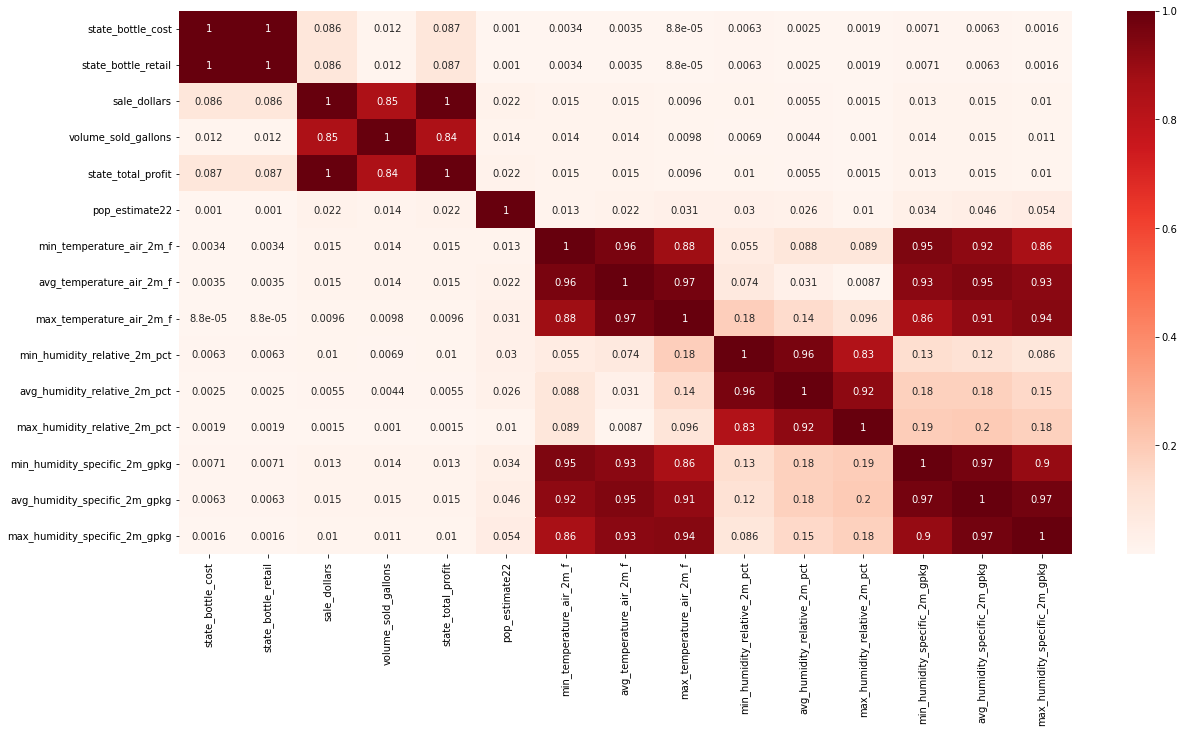

In [ ]:
#Checking for correlation between features
corr_matrix = df.corr().abs()
plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix, annot=True, cmap="Reds")
plt.show()

In [ ]:
#Based on heatmap we can drop the following

#Removing min max temperatures
df=df.drop(columns=['min_temperature_air_2m_f','max_temperature_air_2m_f','min_humidity_relative_2m_pct','max_humidity_relative_2m_pct','min_humidity_specific_2m_gpkg','max_humidity_specific_2m_gpkg'	])

#Remove state bottle cost
df=df.drop(columns=['state_bottle_retail','sale_dollars'])

#Remove one humidity column
df=df.drop(columns=['avg_humidity_specific_2m_gpkg'])

#Remove profit column
df=df.drop(columns=['state_total_profit'])

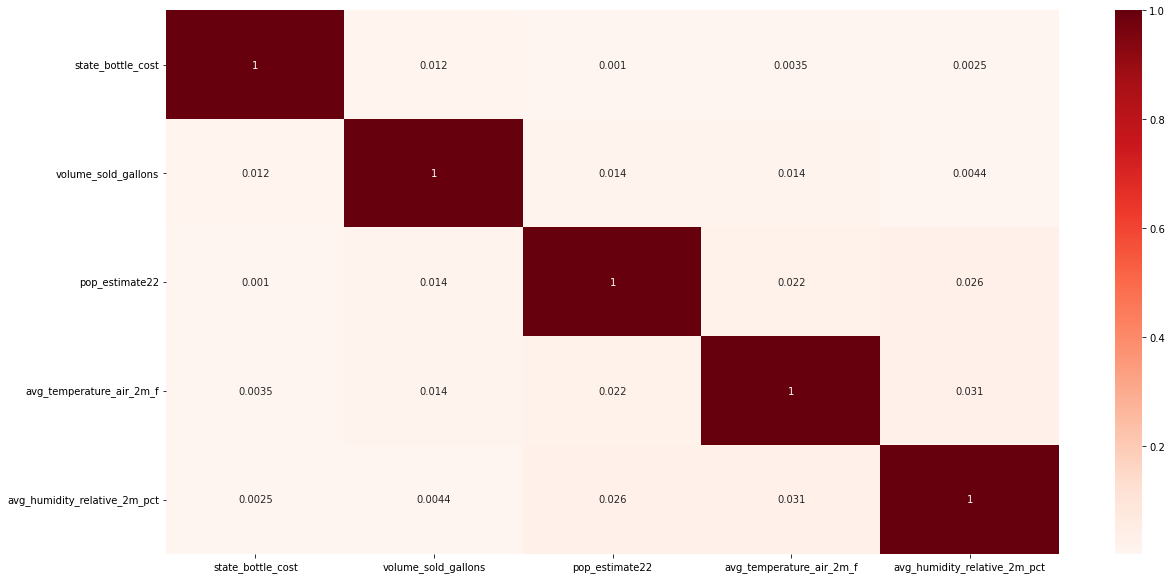

In [ ]:
##Checking for correlation between features
corr_matrix = df.corr().abs()
plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix, annot=True, cmap="Reds")
plt.show()

**Final data frame to export**

Note: Make sure to delete the existing file in drive before running this command

In [ ]:
final_df= df
#Adding the data frame csv to drive
final_df.to_csv(DATA_PATH+"Final_6month_alcohol_data.csv", index = False)

# **TEMPORARY END OF NOTEBOOK**

**Fixing some spelling errors in relevant columns --- Ignore from here**

Remaining since a lot of data needs to be still looked at to find this

In [ ]:
#df.loc[df['City'] == 'Clearlake', 'City'] = 'Clear Lake'
#df.loc[df['City'] == 'Otumwa', 'City'] = 'Ottuwma'
#df.loc[df['City'] == 'Ottumwa', 'City'] = 'Ottuwma'
#df.loc[df['City'] == 'Leclaire', 'City'] = 'Le Claire'
#df.loc[df['City'] == 'Grand Mounds', 'City'] = 'Grand Mound'
#df.isnull().sum()

**Fixing column data and re-mapping**

Remaining since lot of records require looking at

In [ ]:
#renaming & Removing Punctuations
#df.rename(columns={"State Bottle Retail" : "State Bottle Retail ($)", "State Bottle Cost": "State Bottle Cost ($)", "Sale (Dollars)": "Sale ($)"}, inplace=True)
#def remove_punctuation(x):
#    try:
#        x = x.str.replace('[!"#$%\'()*+,-.:;<=>?@[\\]^_`{}~]','')
#    except:
#        pass
#    return x
#df = df.apply(remove_punctuation)
#df[['Store Name', 'City', 'Category Name', 'Vendor Name']] = df[['Store Name', 'City', 'Category Name', 'Vendor Name']].apply(lambda x: x.str.title())
#df

In [ ]:
#df.loc[df['store_name'] == 'Kum & Go 202 / 4Th St Waukee', ['Store Name', 'City']] = 'Kum & Go 202','Waukee'
#df.loc[df['Store Name'] == 'Caseys General Store  2783/ Urband', ['Store Name', 'City']] = 'Caseys General Store 2783', 'Urbandale'
#df.loc[df['Store Name'] == 'Caseys General Store  2783/ Urband', ['Store Name', 'City']] = 'Caseys General Store 2783', 'Urbandale'
#df.loc[df['Store Name'] == 'Caseys General Store  2783/ Urband', ['Store Name', 'City']] = 'Caseys General Store 2783', 'Urbandale'
#df.loc[df['Store Name'] == 'Caseys General Store  2783/ Urband', ['Store Name', 'City']] = 'Caseys General Store 2783', 'Urbandale'
#df.loc[df['Store Name'] == 'Caseys General Store  2783/ Urband', ['Store Name', 'City']] = 'Caseys General Store 2783', 'Urbandale'
#df.loc[df['Store Name'] == 'Caseys General Store 1125 / Humest', ['Store Name', 'City']] = 'Caseys General Store 1125','Humeston'
#df.loc[df['Store Name'] == 'Kum & Go  532/ West Dsm', ['Store Name', 'City']] = 'Kum & Go  532','West Des Moines'
#df.loc[df['Store Name'] == 'Fareway Stores 703 / Humbolt', ['Store Name', 'City']] = 'Fareway Stores 703','Humboldt'
#df.loc[df['Store Name'] == 'D And S Grocery', 'City'] = 'Melcherdallas'
#df.loc[df['Store Name'] == 'Point Liquor & Tobacco', 'City'] = 'Cedar Rapids'
#df.loc[df['Store Name'] == 'North American Spirits', 'City'] = 'Urbandale'
#df.loc[(df['Store Name'] == 'The Secret Cellar') & (df['Date'] < '2017-09-12'), 'City'] = 'Swisher'
#df.loc[(df['Store Name'] == 'The Secret Cellar') & (df['Date'] >= '2017-09-12'), 'City'] = 'Shueyville'
#df.loc[df['Store Name'] == 'Caseys General Store  2560', 'City'] = 'Ames'
#df.loc[df['Store Name'] == 'Gameday Liquor', 'City'] = 'Glenwood'
#df.loc[df['Store Name'] == 'Liquor And Grocery Depot', 'City'] = 'Marshalltown'
#df.loc[df['Store Name'] == 'Express Mart', 'City'] = 'Muscatine'
#df.loc[df['Store Name'] == 'Av Superstop', 'City'] = 'Des Moines'
#df.loc[df['Store Name'] == 'U S Gas', 'City'] = 'Des Moines'
#df.loc[df['Store Name'] == 'River Mart', 'City'] = 'West Burlington'
#df.loc[df['Store Name'] == 'Caseys General Store 1548 / Ankeny', 'City'] = 'Ankeny'
#df.loc[df['Store Name'] == 'Caseys General Store 3075 / Ankeny', 'City'] = 'Ankeny'
#df.loc[df['Store Name'] == 'Hyvee Wine And Spirits / Estherville', 'City'] = 'Estherville'
#df.loc[df['Store Name'] == 'Caseys General Store 3508/ Marsha', 'City'] = 'Marsha'
#df.loc[df['Store Name'] == 'Fareway Stores 151 / Cedar Rapids', 'City'] = 'Cedar Rapids'
#df.loc[df['Store Name'] == 'Mmdg Spirits / Ames', 'City'] ='Ames'
#df.loc[df['Store Name'] == 'Kum & Go 438 / Muscatine', 'City'] = 'Muscatine'
#df.loc[df['Store Name'] == 'Caseys General Store 1567 / Anita', 'City'] = 'Anita'
#df.loc[df['Store Name'] == 'Caseys General Store 1503 / Tabor', 'City'] = 'Tabor'
#df.loc[df['Store Name'] == 'Hyvee Food And Drug 6 / Cedar Rapids', 'City'] ='Cedar Rapids'
#df.loc[df['Store Name'] == 'Caseys General Store 1365 / Paullina','City'] = 'Paullina'
#df.loc[df['Store Name'] == 'Caseys General Store 1680 / Adel', 'City'] = 'Adel'
#df.loc[df['Store Name'] == 'Caseys General Store  2598/ Pella', 'City'] ='Pella'
#df.loc[df['Store Name'] == 'Caseys General Store 1617 / Jefferson', 'City'] = 'Jefferson'
#df.loc[df['Store Name'] == 'Indy 66 West 929 / Indianola', 'City'] = 'Indianola'
#df.loc[df['Store Name'] == 'Kum & Go 4098 / Windsor Heights', 'City'] = 'Windsor Heights'
#df.loc[df['Store Name'] == 'Jeffs Market / Wilton', 'City'] = 'Wilton'
#df.loc[df['Store Name'] == 'Kum & Go 502 / Iowa City', 'City'] = 'Iowa City'
#df.loc[df['Store Name'] == 'Kum & Go 201 / Coralville','City'] = 'Coralville'
#df.loc[df['Store Name'] == 'Kum & Go 768 / Hospers','City'] = 'Hospers'
#df.loc[df['Store Name'] == 'Caseys General Store  2417/ Newton', 'City'] = 'Newton'
#df.loc[df['Store Name'] == 'Caseys General Store 1493 / Van Meter', 'City'] = 'Van Meter'
#df.loc[df['Store Name'] == 'Caseys General Store 1684 / Emmetsburg', 'City'] = 'Emmetsburg'
#df.loc[df['Store Name'] == 'Kum & Go 521  /  Coralville', 'City'] ='Coralville'
#df.loc[df['Store Name'] == 'Kum & Go 540 / Waukee', 'City'] = 'Waukee'
#df.loc[df['Store Name'] == 'Hyvee Drugstore / Council Bluffs', 'City'] = 'Council Bluffs'
#df.loc[df['Store Name'] == 'Fareway Store  167/Johnston', 'City'] ='Johnston'
#df.loc[df['Store Name'] == 'Fas Mart  5150/ Cedar Rapids', 'City'] = 'Cedar Rapids'
#df.loc[df['Store Name'] == 'Kum & Go 83 / Casey', 'City'] = 'Casey'
#df.loc[df['Store Name'] == 'Kum & Go  119/ Northwood', 'City'] = 'Northwood'
#df['Store Name'] = ['Store Name'].str.split(' / ', 1).str[0]
#df.isnull().sum()

In [ ]:
#print((df.groupby('Category')['Category Name'].unique().to_frame()).head(47))
#print((df.groupby('Category')['Category Name'].unique().to_frame()).tail(50))

In [ ]:
#df.loc[df['Category Name'] == 'Single Barrel Bourbon Whiskies', 'Category'] = 1011300.0
#df.loc[df['Category Name'] == 'Temporary & Specialty Packages', 'Category'] = 1700000.0
#df.loc[df['Category Name'] == 'Corn Whiskies', 'Category'] = 1011700.0
#df.loc[df['Category Name'] == 'American Vodkas', ['Category', 'Category Name']] = 1031000.0,'American Vodka'
#df.loc[df['Category Name'] == 'Straight Rye Whiskies', 'Category'] = 1011600.0
#df.loc[df['Category Name'] == 'Bottled In Bond Bourbon', 'Category'] = 1011500.0
#df.loc[df['Category Name'] == 'Tennessee Whiskies', 'Category'] = 1011400.0
#df.loc[df['Category Name'] == 'Single Malt Scotch', 'Category'] = 1012210.0
#df.loc[df['Category Name'] == 'Irish Whiskies', 'Category'] = 1012300.0
#df.loc[df['Category Name'] == 'Flavored Gins', 'Category'] = 1041000.0
#df.loc[df['Category Name'] == 'Cocktails /Rtd', 'Category'] = 1070000.0
#df.loc[df['Category Name'] == 'Spiced Rum', 'Category'] = 1062310.0
#df.loc[df['Category Name'] == 'Imported Vodkas', ['Category', 'Category Name']] = 1032000.0,'American Vodka'
#df.loc[df['Category Name'] == 'Imported Vodka', 'Category'] = 1032000.0
#df.loc[df['Category Name'] == 'Flavored Rum', 'Category'] = 1062500.0
#df.loc[df['Category Name'] == 'Cocktails /Rtd', 'Category Name'] = 'Cocktails / Rtd'
#df.loc[df['Category Name'] == 'Coffee Liqueurs', 'Category'] = 1081030.0
#df.loc[df['Category Name'] == 'American Dry Gins', 'Category'] = 1041100.0
#df.loc[df['Category Name'] == 'American Vodka', 'Category'] = 1031000.0
#df.loc[df['Category Name'] == 'American Sloe Gins', 'Category'] = 1041300.0
#df.loc[df['Category Name'] == 'American Cordials & Liqueurs', 'Category'] = 1081000.0
#df.loc[df['Category Name'] == 'Imported Distilled Spirits Specialty', 'Category'] = 1092000.0
#df.loc[df['Category Name'] == 'Imported Cordials & Liqueur', ['Category', 'Category Name']] = 1082000.0,'Imported Cordials & Liqueurs'
#df.loc[df['Category Name'] == 'American Cordials & Liqueur', ['Category', 'Category Name']] = 1081000,'American Cordials & Liqueurs'
#df.loc[df['Category Name'] == 'Imported Distilled Spirit Specialty', ['Category', 'Category Name']] = 1092000.0,'Imported Distilled Spirits Specialty'
#df.loc[df['Category Name'] == 'Temporary &  Specialty Packages', 'Category Name'] = 'Temporary & Specialty Packages'
#df.loc[df['Category Name'] == 'Vodka Flavored', 'Category Name'] = 'American Flavored Vodka'
#df.loc[df['Category Name'] == 'American Vodka Flavored', 'Category Name'] = 'American Flavored Vodka'
#df.loc[(df['Category Name'] == 'Tequila')|(df['Category Name'] == 'Mixto'), 'Category Name'] = 'Mixto Tequila'
#df.loc[df['Category Name'] == 'Imported Vodka  Misc', 'Category Name'] = 'Imported Flavored Vodka'
#df.loc[df['Category Name'] == 'American Gins', 'Category Name'] = 'Flavored Gins'
#df.loc[(df['Category Name'] == 'Apricot Brandies')|(df['Category Name'] == 'American Brandies'), 'Category Name'] = 'Apricot Brandies (American Brandies)'
#df.loc[(df['Category Name'] == 'Jamaica Rum')|(df['Category Name'] == 'Gold Rum'), 'Category Name'] = 'Jamaica Rum (Gold Rum)'
#df.loc[(df['Category Name'] == 'Puerto Rico & Virgin Islands Rum')|(df['Category Name'] == 'White Rum'), 'Category Name'] = 'Puerto Rico & Virgin Islands Rum (White Rum)'
#df.loc[(df['Category Name'] == 'Triple Sec') & (df['Category'] == 1081400.0), 'Category Name'] = 'American Schnapps (Triple Sec)'
#df.loc[(df['Category Name'] == 'American Schnapps') & (df['Category'] == 1081400.0), 'Category Name'] = 'American Schnapps (Triple Sec)'

In [ ]:
#df['Category Name'].nunique()

In [ ]:
#(df.groupby('City')['City'].unique()).values.tolist()

In [ ]:
#df.dropna(inplace = True)
#df.isnull().sum()

# **END OF NOTEBOOK**